<a href="https://colab.research.google.com/github/lottle2008/Online-education-intelligent-recommendation-model-ASSISTments-2017/blob/main/gai_6_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==========================================
# Phase 0–1 强力修复版（带详细自检日志）
# 目标：稳定产出 users.csv / videos.csv / video_concept_edges.csv / watch_logs.csv
# ==========================================

import os, glob, json, io, csv
import numpy as np
import pandas as pd

DATASET_FOLDER = "/content/drive/MyDrive/gai/data"   # <- 按需修改
OUTPUT_DIR      = os.path.join(DATASET_FOLDER, "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📂 扫描文件夹：", DATASET_FOLDER)
paths = sorted(glob.glob(os.path.join(DATASET_FOLDER, "student_log_*.csv")))
if not paths:
    raise FileNotFoundError(f"❌ 未找到 {DATASET_FOLDER} 下的 student_log_*.csv")

def _try_read(path):
    # 1) 优先智能分隔符探测（含BOM清理）
    for enc in ("utf-8-sig", "utf-8", "latin1"):
        try:
            with open(path, "r", encoding=enc, newline="") as f:
                sample = f.read(4096)
            # 猜分隔符：逗号/制表/分号
            sniffer = csv.Sniffer()
            dialect = sniffer.sniff(sample, delimiters=[",", "\t", ";"])
            sep = dialect.delimiter
            df = pd.read_csv(path, sep=sep, encoding=enc, engine="python")
            return df, enc, sep
        except Exception as e:
            last_err = str(e)
    # 2) 兜底方案
    try:
        df = pd.read_csv(path, sep=None, engine="python")
        return df, "auto", "auto"
    except Exception as e:
        raise RuntimeError(f"读取失败: {path} | 最近错误: {last_err} / {e}")

def _clean_colnames(cols):
    seen = {}
    out = []
    for c in cols:
        # 去BOM与首尾空白
        cc = c.replace("\ufeff", "").strip()
        # 避免重复列名：追加后缀
        base = cc
        k = 1
        while cc in seen:
            k += 1
            cc = f"{base}__dup{k}"
        seen[cc] = 1
        out.append(cc)
    return out

def _norm_key(s):
    # 宽松匹配：小写 + 去空白 + 去下划线
    return s.replace("\ufeff","").strip().lower().replace(" ", "").replace("_","")

def _resolve(want, cols):
    wantk = _norm_key(want)
    for c in cols:
        if _norm_key(c) == wantk:
            return c
    return None

dfs = []
meta = []
for p in paths:
    df_raw, enc, sep = _try_read(p)
    old = list(df_raw.columns)
    df_raw.columns = _clean_colnames(df_raw.columns.map(lambda s: str(s)))
    print(f"  • 读取: {os.path.basename(p)} | 编码={enc} 分隔符={'TAB' if sep=='\\t' else sep} | 列数 {len(df_raw.columns)}")
    if old != list(df_raw.columns):
        print("    ↪ 列名去重/清洗后示例:", list(df_raw.columns)[:12])
    dfs.append(df_raw)
    meta.append((enc, sep))

df = pd.concat(dfs, ignore_index=True)
print(f"✅ 合并完成，总记录数: {len(df):,}，总列数: {len(df.columns)}")
print("🧭 现有列名前20个:", list(df.columns)[:20])

# 你给出的关键源列名
need_cols = {
    "ITEST_id":  "user_id",
    "problemId": "video_id",
    "skill":     "concept",
    "correct":   "is_correct",
}
time_candidates = ["actionId", "startTime"]

# 宽松解析：把每个需求列映射到实际命中的源列名
resolved = {}
for raw, std in need_cols.items():
    hit = _resolve(raw, df.columns)
    resolved[std] = hit

time_hit = None
for t in time_candidates:
    hit = _resolve(t, df.columns)
    if hit is not None and df[hit].notna().any():
        time_hit = hit
        break

print("\n🔎 列匹配结果（原始 → 统一）：")
for std, hit in resolved.items():
    print(f"   {std:<11} <= {str(hit)}")
print(f"   {'timestamp':<11} <= {str(time_hit)}")

# 如果有任何关键列没命中，给出诊断并退出
missing_std = [k for k,v in resolved.items() if v is None]
if time_hit is None:
    missing_std.append("timestamp")
if missing_std:
    print("\n❌ 关键列未命中：", missing_std)
    print("📋 现有全部列名（前50）:", list(df.columns)[:50])
    raise SystemExit("请检查原始文件的表头是否与提供的清单一致（是否为TSV/分号分隔、是否有BOM、是否无表头等）。")

# 只选需要的列并**显式构造**统一列，避免 rename 漏网
df_std = pd.DataFrame({
    "user_id":   df[resolved["user_id"]],
    "video_id":  df[resolved["video_id"]],
    "concept":   df[resolved["concept"]],
    "is_correct":pd.to_numeric(df[resolved["is_correct"]], errors="coerce"),
    "timestamp": df[time_hit]
})

# 基础清洗
before = len(df_std)
df_std = df_std.dropna(subset=["user_id","video_id","concept"]).copy() # Add .copy() to avoid SettingWithCopyWarning
after = len(df_std)
print(f"\n🧹 剔除关键列缺失: {before-after:,} 条，保留 {after:,}")

df_std["user_id"]  = df_std["user_id"].astype(str).str.strip()
df_std["video_id"] = df_std["video_id"].astype(str).str.strip()
df_std["concept"]  = df_std["concept"].astype(str).str.strip()
df_std["is_correct"]= df_std["is_correct"].fillna(0).astype(int).clip(0,1)

# 统一时间戳：数字→int；字符串→解析为秒
if pd.api.types.is_numeric_dtype(df_std["timestamp"]):
    df_std["timestamp"] = pd.to_numeric(df_std["timestamp"], errors="coerce")
    df_std = df_std.dropna(subset=["timestamp"]).copy() # Add .copy()
    df_std["timestamp"] = df_std["timestamp"].astype(np.int64)
else:
    ts = pd.to_datetime(df_std["timestamp"], errors="coerce", utc=False)
    df_std = df_std[ts.notna()].copy() # Add .copy()
    df_std["timestamp"] = (ts[ts.notna()].astype("int64") // 10**9).astype(np.int64)

# 排序 + 过滤 <5 次交互用户 + 每人保留最近100条
df_std = df_std.sort_values(["user_id","timestamp"]).reset_index(drop=True)
user_cnt = df_std.groupby("user_id").size()
valid_users = user_cnt[user_cnt >= 5].index
df_std = df_std[df_std["user_id"].isin(valid_users)].copy().reset_index(drop=True) # Add .copy()
print(f"👥 过滤交互<5：用户 {df_std['user_id'].nunique():,}，记录 {len(df_std):,}")

def _tail100(g): return g.tail(100)
try:
    # Ensure 'user_id' is part of the grouped output by not dropping it
    df_std = df_std.groupby("user_id").apply(_tail100, include_groups=False).reset_index()
except TypeError:
    df_std = df_std.groupby("user_id", group_keys=False, sort=False, observed=True).apply(_tail100).reset_index()

print(f"⏩ 每用户截断到最近100条后，总记录: {len(df_std):,}")

# Add a check to ensure 'user_id' column exists
if 'user_id' not in df_std.columns:
    print("\n❌ Error: 'user_id' column is missing after filtering and truncation.")
    print("📋 Columns after processing:", df_std.columns.tolist())
    raise KeyError("'user_id' column not found after processing.")


# ===== 导出四表 + 三映射 =====
users = pd.DataFrame({"user_id": sorted(df_std["user_id"].unique())})
videos = pd.DataFrame({"video_id": sorted(df_std["video_id"].unique())})
video_concept = df_std[["video_id","concept"]].drop_duplicates().rename(columns={"concept":"concept_id"})
logs = df_std[["user_id","video_id","is_correct","timestamp"]].sort_values(["user_id","timestamp"]).reset_index(drop=True)

users.to_csv(os.path.join(OUTPUT_DIR, "users.csv"), index=False)
videos.to_csv(os.path.join(OUTPUT_DIR, "videos.csv"), index=False)
video_concept.to_csv(os.path.join(OUTPUT_DIR, "video_concept_edges.csv"), index=False)
logs.to_csv(os.path.join(OUTPUT_DIR, "watch_logs.csv"), index=False)

user2idx = {u:i for i,u in enumerate(users["user_id"].tolist())}
item2idx = {v:i for i,v in enumerate(videos["video_id"].tolist())}
concept2idx = {c:i for i,c in enumerate(sorted(video_concept["concept_id"].unique().tolist()))}

with open(os.path.join(OUTPUT_DIR, "user2idx.json"), "w") as f: json.dump(user2idx, f)
with open(os.path.join(OUTPUT_DIR, "item2idx.json"), "w") as f: json.dump(item2idx, f)
with open(os.path.join(OUTPUT_DIR, "concept2idx.json"), "w") as f: json.dump(concept2idx, f)

print("\n✅ 导出完成：", OUTPUT_DIR)
for f in ["users.csv","videos.csv","video_concept_edges.csv","watch_logs.csv",
          "user2idx.json","item2idx.json","concept2idx.json"]:
    p = os.path.join(OUTPUT_DIR, f)
    print(" -", f, "✔️" if os.path.exists(p) else "❌")

# 最后一眼安全检查
print("\n🧪 统一数据帧列名确认：", list(df_std.columns))
print(df_std.head(3).to_string(index=False))

📂 扫描文件夹： /content/drive/MyDrive/gai/data
  • 读取: student_log_1.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_10.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_2.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_3.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_4.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_5.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_6.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_7.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_8.csv | 编码=auto 分隔符=auto | 列数 76
  • 读取: student_log_9.csv | 编码=auto 分隔符=auto | 列数 76
✅ 合并完成，总记录数: 942,816，总列数: 77
🧭 现有列名前20个: ['ITEST_id', 'SY ASSISTments Usage', 'AveKnow', 'AveCarelessness', 'AveCorrect', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask', 'AveResGaming', 'actionId', 'skill', 'problemId', 'assignmentId', 'assistmentId', 'startTime', 'endTime', 'timeTaken']

🔎 列匹配结果（原始 → 统一）：
   user_id     <= ITEST_id
   video_id    <= problemId
   concept     <= skil

In [2]:
# ====== 环境 & 工具函数（与改进后的 Phase 0 对齐版） ======
import os, random, math, json, time, gc
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --------------------------
# 复现性：固定随机种子
# --------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)

# --------------------------
# 设备
# --------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
#和下面的拆分了，中间加了一个下面这一段

Device: cuda


In [4]:
# === Global: reproducibility & helpers (NEW) ===
def set_seed(seed=2025):
    import os, random, numpy as np, torch
    random.seed(seed); np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)

import torch.nn.functional as F
def sanitize_and_save(path, emb_tensor):
    emb_tensor = torch.nan_to_num(emb_tensor, nan=0.0, posinf=0.0, neginf=0.0)
    emb_tensor = F.normalize(emb_tensor, p=2, dim=1)  # L2 归一
    np.save(path, emb_tensor.detach().cpu().numpy())


In [5]:


# --------------------------
# 路径：与 Phase 0 改进版保持一致
# - Phase 0 输出到  /content/drive/MyDrive/gai/data/processed
# - 下面常量用于后续模块统一引用
# --------------------------
PROJECT_ROOT = "/content/drive/MyDrive/gai"
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, "data")                 # 原始数据文件夹（可不用）
PROCESSED_DIR = os.path.join(RAW_DATA_DIR, "processed")           # Phase 0 的输出目录
os.makedirs(PROCESSED_DIR, exist_ok=True)

USERS_CSV   = os.path.join(PROCESSED_DIR, "users.csv")
VIDEOS_CSV  = os.path.join(PROCESSED_DIR, "videos.csv")
VC_EDGES_CSV= os.path.join(PROCESSED_DIR, "video_concept_edges.csv")
LOGS_CSV    = os.path.join(PROCESSED_DIR, "watch_logs.csv")

USER2IDX_JSON    = os.path.join(PROCESSED_DIR, "user2idx.json")
ITEM2IDX_JSON    = os.path.join(PROCESSED_DIR, "item2idx.json")
CONCEPT2IDX_JSON = os.path.join(PROCESSED_DIR, "concept2idx.json")

# （可选）快速一致性检查：确保 Phase 0 的四表与三份映射存在
def _check_phase0_outputs():
    needed = [USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
              USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON]
    missing = [p for p in needed if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(
            "缺少 Phase 0 生成的文件，请先运行数据清洗与标准化步骤：\n" +
            "\n".join([" - " + m for m in missing])
        )
    else:
        print("✅ 已检测到 Phase 0 输出：users/videos/edges/logs 及三份 *2idx.json")

# 在 notebook 里可以取消下一行注释做一次自检
# _check_phase0_outputs()

# --------------------------
# 早停器：训练过程监控
# --------------------------
class EarlyStopping:
    def __init__(self, patience=5, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    def __call__(self, score, model=None):
        improve = False
        if self.best_score is None:
            improve = True
        else:
            if self.mode == "min":
                improve = score < self.best_score - self.delta
            else:
                improve = score > self.best_score + self.delta
        if improve:
            self.best_score = score
            self.counter = 0
            if model is not None:
                # 存 CPU 拷贝，避免显存占用
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --------------------------
# 评估指标（Top-K / AUC 等）
# --------------------------
def recall_at_k(y_true, y_pred_ranked, k):
    return len(y_true.intersection(set(y_pred_ranked[:k]))) / max(1, len(y_true))

def dcg_at_k(y_true, y_pred_ranked, k):
    dcg = 0.0
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            dcg += 1.0 / math.log2(i + 1)
    return dcg

def ndcg_at_k(y_true, y_pred_ranked, k):
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, ideal_hits + 1))
    if idcg == 0: return 0.0
    return dcg_at_k(y_true, y_pred_ranked, k) / idcg

def hit_rate_at_k(y_true, y_pred_ranked, k):
    return 1.0 if len(y_true.intersection(set(y_pred_ranked[:k]))) > 0 else 0.0

def mrr_at_k(y_true, y_pred_ranked, k):
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            return 1.0 / i
    return 0.0

def binary_auc(pos_score, neg_scores):
    greater = sum(pos_score > ns for ns in neg_scores)
    ties = sum(pos_score == ns for ns in neg_scores)
    n = len(neg_scores)
    if n == 0: return 0.5
    return (greater + 0.5 * ties) / n

# --------------------------
# 通用：保存 JSON（UTF-8）
# --------------------------
def save_json(obj, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

In [6]:
# ==========================
# ✅ 从 watch_logs.csv 构建用户行为序列（与 Phase 0/环境常量对齐）
# 产物：PROCESSED_DIR/user_sequences.npy（list[dict]，含原始ID与索引）
#      PROCESSED_DIR/user_sequences.jsonl（可读性检查用）
# ==========================

import os, json
import numpy as np
import pandas as pd

# 这些常量来自“环境 & 工具函数”单元
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# --- 1) 加载 Phase 0 输出 ---
assert os.path.exists(LOGS_CSV), f"❌ 未找到交互日志: {LOGS_CSV}"
assert os.path.exists(USER2IDX_JSON) and os.path.exists(ITEM2IDX_JSON), \
    "❌ 缺少 user2idx.json 或 item2idx.json，请先运行 Phase 0"

print(f"📘 加载交互日志: {LOGS_CSV}")
logs = pd.read_csv(LOGS_CSV)

with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)

# --- 2) 列名检查与排序（严格时间序） ---
expected_cols = {"user_id", "video_id", "timestamp"}
miss = expected_cols - set(logs.columns)
assert not miss, f"❌ 日志列名缺失: {miss}，需要包含 {expected_cols}"

# Phase 0 已保证 timestamp 为整型且用户内升序；此处再稳妥排序一次
logs = logs.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

# --- 3) 生成每个用户的行为序列 ---
# 重要：不去重，保留同一用户对同一题目的多次交互（保持真实时间信号）
user_sequences = []
n_skipped_short = 0
for uid, g in logs.groupby("user_id", sort=False):
    items_str = g["video_id"].astype(str).tolist()
    # Phase 0 已过滤<5交互用户，这里只略微容错（<2则跳过）
    if len(items_str) < 2:
        n_skipped_short += 1
        continue
    # 映射到统一索引（若遇到未映射ID则跳过该条）
    uidx = user2idx.get(str(uid), None)
    # 极少数不在映射中的用户直接跳过（理论上 Phase 0 不会发生）
    if uidx is None:
        continue
    items_idx = []
    for vid in items_str:
        ix = item2idx.get(str(vid), None)
        if ix is not None:
            items_idx.append(ix)
    # 若映射后长度过短，则跳过
    if len(items_idx) < 2:
        n_skipped_short += 1
        continue

    user_sequences.append({
        "user_id": str(uid),
        "user_idx": int(uidx),
        "pos_items": items_str,       # 原始 video_id 列表（字符串）
        "pos_item_idx": items_idx     # 统一索引后的 item 列表（整数）
    })

print(f"✅ 构建完毕: {len(user_sequences)} 个用户序列；跳过过短序列: {n_skipped_short}")

# --- 4) 保存（.npy + .jsonl） ---
out_npy = os.path.join(PROCESSED_DIR, "user_sequences.npy")
np.save(out_npy, np.array(user_sequences, dtype=object), allow_pickle=True)
print(f"💾 已保存: {out_npy}")

# 额外：保存 JSONL 便于抽样检查
out_jsonl = os.path.join(PROCESSED_DIR, "user_sequences.jsonl")
with open(out_jsonl, "w", encoding="utf-8") as f:
    for rec in user_sequences[:200]:  # 只写前200条，避免超大文件
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print(f"📝 已保存样例: {out_jsonl}（前200条）")

# --- 5) 打印一个示例 ---
if len(user_sequences) > 0:
    print("示例:", {k: (v if k in ["user_id","user_idx"] else f"{len(v)} 项")
                  for k, v in user_sequences[0].items()})


📘 加载交互日志: /content/drive/MyDrive/gai/data/processed/watch_logs.csv
✅ 构建完毕: 1708 个用户序列；跳过过短序列: 0
💾 已保存: /content/drive/MyDrive/gai/data/processed/user_sequences.npy
📝 已保存样例: /content/drive/MyDrive/gai/data/processed/user_sequences.jsonl（前200条）
示例: {'user_id': '8', 'user_idx': 1655, 'pos_items': '100 项', 'pos_item_idx': '100 项'}


In [ ]:
# ====== Phase 1-①: Time-holdout 安全切分（对齐 Phase 0 保存格式；鲁棒加载） ======
import os, json, numpy as np

# 复用上游常量
try:
    PROCESSED_DIR
except NameError:
    PROJECT_ROOT = "/content/drive/MyDrive/lun"
    PROCESSED_DIR = os.path.join(PROJECT_ROOT, "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

# 兼容 DATA_DIR（有些旧单元写到 /data）
try:
    DATA_DIR
except NameError:
    DATA_DIR = os.path.join(PROJECT_ROOT, "data")

# —— 输入候选（优先 PROCESSED_DIR）——
CANDIDATES = [
    os.path.join(PROCESSED_DIR, "user_sequences.npy"),
    os.path.join(DATA_DIR,      "user_sequences.npy"),
]
USER_SEQ_PATH = next((p for p in CANDIDATES if os.path.exists(p)), None)
if USER_SEQ_PATH is None:
    raise FileNotFoundError("未找到 user_sequences.npy，请先运行 Phase 0。"
                            f"\n尝试位置：\n - {CANDIDATES[0]}\n - {CANDIDATES[1]}")

# —— 输出路径（写回 PROCESSED_DIR，供 Phase 4/5/6 使用）——
TRAIN_PATH = os.path.join(PROCESSED_DIR, "train_sequences.npy")
VALID_PATH = os.path.join(PROCESSED_DIR, "valid_sequences.npy")
TEST_PATH  = os.path.join(PROCESSED_DIR, "test_sequences.npy")

# —— 切分参数 ——
MIN_LEN, VALID_TAIL, TEST_TAIL = 3, 2, 1
SEED = 2025
np.random.seed(SEED)

def _coerce_from_list_of_dict(lst):
    """
    典型 Phase 0 产物：list[dict]，键包含：
      'user_idx': int, 'pos_item_idx': list[int]
    （也兼容 'hist'/'sequence'/'items' 字段名）
    """
    out = {}
    for rec in lst:
        if not isinstance(rec, dict):
            continue
        # user id
        uid = None
        for k in ("user_idx", "uid", "user"):
            if k in rec:
                uid = int(rec[k]); break
        if uid is None:
            continue
        # sequence
        seq = None
        for k in ("pos_item_idx", "hist", "sequence", "items"):
            if k in rec:
                seq = rec[k]; break
        if seq is None and "events" in rec:
            seq = rec["events"]  # 已按时间排序的 item 列表或 (item, ts)
        if seq is None:
            seq = []
        out[uid] = [int(x) for x in seq]
    return out

def _coerce_from_obj(obj):
    """将各种 numpy/list 包装统一成 {u:[items]}"""
    # dict 形式： {u:[...]} 或 {u:{...}}
    if isinstance(obj, dict):
        vals = list(obj.values())
        if len(vals) == 0:
            return {}
        if isinstance(vals[0], (list, tuple)):
            return {int(k): [int(x) for x in v] for k, v in obj.items()}
        if isinstance(vals[0], dict):
            return _coerce_from_list_of_dict([{**v, "user_idx": int(k)} for k, v in obj.items()])

    # list / tuple：可能是 [dict,...] 或 [(u, seq), ...]
    if isinstance(obj, (list, tuple)):
        # list of dict
        if len(obj) > 0 and isinstance(obj[0], dict):
            return _coerce_from_list_of_dict(obj)
        # list of (u, seq)
        out = {}
        for rec in obj:
            if isinstance(rec, (list, tuple)) and len(rec) == 2:
                u, seq = rec
                out[int(u)] = [int(x) for x in (seq or [])]
        if out:
            return out

    # numpy 数组：object
    if isinstance(obj, np.ndarray):
        if obj.shape == ():  # 0 维标量数组（单个对象）
            return _coerce_from_obj(obj.item())
        if obj.dtype == object:
            # 单元素数组，元素可能是 list 或 dict
            if obj.size == 1:
                return _coerce_from_obj(obj.ravel()[0])
            # 常见：一维对象数组，每个元素是 dict
            # 优先尝试把它“视作列表”
            return _coerce_from_list_of_dict(list(obj))

    # 兜底：失败
    raise ValueError("无法从该对象推断出 {user:[items]} 结构。")

# —— 读取 & 解析 ——
raw_obj = np.load(USER_SEQ_PATH, allow_pickle=True)
try:
    user_sequences = _coerce_from_obj(raw_obj)
except Exception as e:
    # 尝试从 JSONL（Phase 0 样例文件）恢复
    JSONL_CAND = [
        os.path.join(PROCESSED_DIR, "user_sequences.jsonl"),
        os.path.join(DATA_DIR,      "user_sequences.jsonl"),
    ]
    jsonl_path = next((p for p in JSONL_CAND if os.path.exists(p)), None)
    if jsonl_path is None:
        # 打印诊断信息帮助定位
        preview = f"type={type(raw_obj)}, shape={getattr(raw_obj,'shape',None)}, dtype={getattr(raw_obj,'dtype',None)}"
        raise ValueError(f"无法解析 user_sequences.npy；也未找到 JSONL 兜底。\n"
                         f"载入对象预览：{preview}\n原始错误：{repr(e)}")
    # 解析 JSONL 前 50 条尝试恢复
    lst = []
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            try:
                lst.append(json.loads(line))
            except:
                pass
            if i >= 1000:  # 足够恢复结构
                break
    user_sequences = _coerce_from_list_of_dict(lst)

# —— 时间留出切分 ——
def split_by_time_holdout(user_sequences: dict, min_len=MIN_LEN, valid_tail=VALID_TAIL, test_tail=TEST_TAIL):
    train, valid, test = {}, {}, {}
    kept, dropped = 0, 0
    for u, seq in user_sequences.items():
        seq = [int(x) for x in seq]
        if len(seq) < (min_len + valid_tail + test_tail):
            dropped += 1; continue
        head = seq[:-(valid_tail + test_tail)]
        vseq = seq[-(valid_tail + test_tail):-test_tail]
        tseq = seq[-test_tail:]
        if len(head) >= min_len and len(vseq) >= 1 and len(tseq) >= 1:
            train[int(u)] = head
            valid[int(u)] = vseq
            test[int(u)]  = tseq
            kept += 1
        else:
            dropped += 1
    return train, valid, test, kept, dropped

train_seq, valid_seq, test_seq, kept, dropped = split_by_time_holdout(user_sequences)

def _stats(name, d):
    total = sum(len(v) for v in d.values())
    avg = total / max(len(d),1) if len(d)>0 else 0.0
    print(f" - {name}: users={len(d):4d}, total_events={total:7d}, avg_len={avg:5.2f}")

print(f"📥 Loaded from: {USER_SEQ_PATH}")
print(f"✅ Time-holdout split done. kept={kept}, dropped={dropped}")
_stats("TRAIN", train_seq); _stats("VALID", valid_seq); _stats("TEST ", test_seq)

# —— 保存为三份 dict（供 Phase 4/5/6）——
np.save(TRAIN_PATH, train_seq, allow_pickle=True)
np.save(VALID_PATH, valid_seq, allow_pickle=True)
np.save(TEST_PATH,  test_seq,  allow_pickle=True)
print(f"💾 Saved:\n - {TRAIN_PATH}\n - {VALID_PATH}\n - {TEST_PATH}")

# 轻量校验
if len(train_seq)>0 and len(valid_seq)>0 and len(test_seq)>0:
    any_u = next(iter(train_seq.keys()))
    print(f"🔎 Sanity check user={any_u}: head={len(train_seq[any_u])}, valid={len(valid_seq[any_u])}, test={len(test_seq[any_u])}")


📥 Loaded from: /content/drive/MyDrive/gai/data/processed/user_sequences.npy
✅ Time-holdout split done. kept=1708, dropped=0
 - TRAIN: users=1708, total_events= 163800, avg_len=95.90
 - VALID: users=1708, total_events=   3416, avg_len= 2.00
 - TEST : users=1708, total_events=   1708, avg_len= 1.00
💾 Saved:
 - /content/drive/MyDrive/gai/data/processed/train_sequences.npy
 - /content/drive/MyDrive/gai/data/processed/valid_sequences.npy
 - /content/drive/MyDrive/gai/data/processed/test_sequences.npy
🔎 Sanity check user=1655: head=97, valid=2, test=1


In [ ]:
# ==========================
# ✅ Phase 1: Sliding-Window + Hard Negatives（与 Phase 0 / 环境常量 / 序列文件 完全对齐）
# 读入：PROCESSED_DIR/user_sequences.npy（含 user_idx 、pos_item_idx）
#      PROCESSED_DIR/user2idx.json / item2idx.json
# 产出：train_pairs.npy     -> (user_idx, pos_item_idx, neg_item_idx) 三元组
#       train_slices.npy    -> list[dict]: {user_idx, hist, pos, neg}（hist 为索引序列）
#       item_freq.json      -> 物品频次（用于负采样复现）
# ==========================

import os, json, random
import numpy as np
from collections import Counter

# ----- 来自“环境 & 工具函数”的常量 -----
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# --------------------------
# 0) 路径与输入检查
# --------------------------
seq_path = os.path.join(PROCESSED_DIR, "user_sequences.npy")
assert os.path.exists(seq_path), f"❌ 缺少行为序列：{seq_path}"
assert os.path.exists(USER2IDX_JSON) and os.path.exists(ITEM2IDX_JSON), \
    "❌ 缺少 user2idx.json 或 item2idx.json，请先完成 Phase 0"

print(f"📘 加载用户行为序列: {seq_path}")
user_seqs = np.load(seq_path, allow_pickle=True)

with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)

n_items = len(item2idx)
all_item_idx = np.arange(n_items)

# --------------------------
# 1) 物品流行度统计（用于加权负采样）
# --------------------------
pop_counter = Counter()
for rec in user_seqs:
    # 使用索引序列统计频次（Phase 0 已经统一索引）
    for it in rec["pos_item_idx"]:
        pop_counter[int(it)] += 1

item_freq = {int(k): int(v) for k, v in pop_counter.items()}
with open(os.path.join(PROCESSED_DIR, "item_freq.json"), "w", encoding="utf-8") as f:
    json.dump(item_freq, f, ensure_ascii=False, indent=2)
print(f"📊 物品流行度统计完成：覆盖 {len(item_freq)} / {n_items} 个物品")

# --------------------------
# 2) 语义嵌入（可选）：用于 Hard Negative 候选
#    - 优先找 PROCESSED_DIR/fusion_item_embs.npy（融合后的向量）
#    - 其次找 PROCESSED_DIR/item_model_embs.npy（任意现有物品向量）
# --------------------------
item_emb = None
for cand in ["fusion_item_embs.npy", "item_model_embs.npy"]:
    p = os.path.join(PROCESSED_DIR, cand)
    if os.path.exists(p):
        arr = np.load(p)
        # 对齐维度：如果文件里数量与 n_items 不一致，则放弃语义策略
        if arr.shape[0] == n_items:
            # 归一化，便于余弦相似
            norm = np.linalg.norm(arr, axis=1, keepdims=True) + 1e-12
            item_emb = (arr / norm).astype(np.float32)
            print(f"✅ 启用语义负采样：{cand} 维度 = {arr.shape[1]}")
        else:
            print(f"ℹ️ 跳过 {cand}：数量 {arr.shape[0]} 与映射 n_items={n_items} 不一致")
        break
if item_emb is None:
    print("ℹ️ 未检测到可用物品嵌入，Hard Neg 将退化为流行度/随机负采样。")

# --------------------------
# 3) Hard Negative 策略（函数化）
#    - 语义相似：从与正样本最相似的若干物品中挑选（排除历史与正样本）
#    - 流行度加权：按 freq^alpha 采样（alpha∈(0,1)，默认0.75）
#    - 随机兜底：候选集里随机挑
# --------------------------
def sample_semantic_hard_neg(pos_idx: int, forbid: set, top_m: int = 50):
    """从语义相似物品里选一个不在 forbid 的负样本；失败则返回 None"""
    if item_emb is None:
        return None
    # 相似度 = 余弦（因为已归一化，点积即相似）
    sim = item_emb @ item_emb[pos_idx]
    # 排序取前 top_m（排除自己）
    # argsort 默认升序，取[-(top_m+1):] 再逆序
    cand = np.argsort(sim)[-(top_m+1):][::-1]
    for c in cand:
        if c == pos_idx:  # 跳过自己
            continue
        if c not in forbid:
            return int(c)
    return None

def sample_popularity_neg(forbid: set, alpha: float = 0.75, max_try: int = 20):
    """按 freq^alpha 进行加权采样（forbid 中的都不能选），失败兜底随机"""
    # 预构造权重
    # 注意：有些物品可能 freq=0（没在序列中出现），给一个很小权重
    weights = np.zeros(n_items, dtype=np.float64)
    for i in range(n_items):
        f = item_freq.get(i, 0)
        weights[i] = (f ** alpha) if f > 0 else 1e-6
    # 将 forbid 的权重置零
    if forbid:
        idx_forbid = np.fromiter(forbid, dtype=int, count=len(forbid))
        weights[idx_forbid] = 0.0
    s = weights.sum()
    if s <= 0:
        # 兜底随机
        pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
        return int(np.random.choice(pool)) if len(pool) else None
    prob = weights / s
    # 多尝试几次，避免极端情况下采到 forbid
    for _ in range(max_try):
        c = int(np.random.choice(all_item_idx, p=prob))
        if c not in forbid:
            return c
    # 兜底随机
    pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
    return int(np.random.choice(pool)) if len(pool) else None

def sample_negative(pos_idx: int, forbid: set, use_semantic_prob: float = 0.5):
    """混合策略：以一定概率走语义 HardNeg，否则用流行度；都失败则随机"""
    # 先试语义
    if item_emb is not None and random.random() < use_semantic_prob:
        neg = sample_semantic_hard_neg(pos_idx, forbid)
        if neg is not None:
            return neg
    # 再试流行度
    neg = sample_popularity_neg(forbid)
    if neg is not None:
        return neg
    # 最后随机兜底
    pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
    return int(np.random.choice(pool)) if len(pool) else None

# --------------------------
# 4) 滑动窗口切片
#    - WINDOW: 最多看最近 WINDOW 条历史
#    - STRIDE: 滑动步长
#    - MIN_HIST: 最少历史长度门槛（保证监督信号）
# --------------------------
WINDOW   = 50
STRIDE   = 5
MIN_HIST = 5

pairs = []       # (u, pos, neg)
slices = []      # dict: {user_idx, hist(list[int]), pos(int), neg(int)}

n_short, n_no_neg = 0, 0

for rec in user_seqs:
    u = int(rec["user_idx"])
    seq = [int(x) for x in rec["pos_item_idx"]]
    if len(seq) < MIN_HIST + 1:
        n_short += 1
        continue

    # 生成切片：hist -> target（正样本）
    # end 从 MIN_HIST 到 len(seq)-1，步长 STRIDE
    for end in range(MIN_HIST, len(seq), STRIDE):
        start = max(0, end - WINDOW)
        hist = seq[start:end]       # 历史窗口
        pos  = seq[end]             # 当前正样本
        # forbid 集：历史 + 正样本（避免采到用户已看过的物品）
        forbid = set(hist); forbid.add(pos)

        neg = sample_negative(pos, forbid)
        if neg is None:
            n_no_neg += 1
            continue

        pairs.append((u, pos, neg))
        slices.append({"user_idx": u, "hist": hist, "pos": pos, "neg": neg})

print(f"✅ 样本构建完成：pairs={len(pairs):,}，slices={len(slices):,}（跳过短序列 {n_short}，无可采负样本 {n_no_neg}）")

# --------------------------
# 5) 保存产物（到 PROCESSED_DIR）
# --------------------------
pairs_path  = os.path.join(PROCESSED_DIR, "train_pairs.npy")
slices_path = os.path.join(PROCESSED_DIR, "train_slices.npy")
np.save(pairs_path,  np.array(pairs,  dtype=np.int32))
np.save(slices_path, np.array(slices, dtype=object), allow_pickle=True)
print(f"💾 已保存：\n - {pairs_path}\n - {slices_path}")
print("🎯 Phase 1 完成：滑窗样本 + 困难负样本 已可直接用于后续模型训练。")


📘 加载用户行为序列: /content/drive/MyDrive/gai/data/processed/user_sequences.npy
📊 物品流行度统计完成：覆盖 3538 / 3538 个物品
✅ 启用语义负采样：fusion_item_embs.npy 维度 = 64
✅ 样本构建完成：pairs=32,103，slices=32,103（跳过短序列 0，无可采负样本 0）
💾 已保存：
 - /content/drive/MyDrive/gai/data/processed/train_pairs.npy
 - /content/drive/MyDrive/gai/data/processed/train_slices.npy
🎯 Phase 1 完成：滑窗样本 + 困难负样本 已可直接用于后续模型训练。


In [ ]:
import torch
print(torch.__version__)
!nvcc --version | grep release


2.8.0+cu126
Cuda compilation tools, release 12.5, V12.5.82


In [ ]:

# 卸载旧版本，避免冲突
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y

# 安装 PyG 及依赖（匹配 Torch 2.8.0 + CUDA 12.1）
!pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00


In [ ]:
# ===========================================
# ✅ Phase 2-A: 异构图构建（与 Phase 0/1 完全对齐）
# 读取：PROCESSED_DIR/users.csv, videos.csv, video_concept_edges.csv, watch_logs.csv
#       user2idx.json, item2idx.json, concept2idx.json
# 产出：hetero_edge_stats.json（关系规模统计，便于论文引用）
#       （图本身直接以内存 HeteroData 形式供下个单元使用）
# ===========================================
import os, json
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
from torch_geometric.data import HeteroData

# ==== 路径常量（来自“环境 & 工具函数”单元）====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# 基础文件检查
needed = [USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
          USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON]
miss = [p for p in needed if not os.path.exists(p)]
assert not miss, "❌ 缺少文件：\n" + "\n".join([" - " + m for m in miss])

# 读取数据
users_df  = pd.read_csv(USERS_CSV)
items_df  = pd.read_csv(VIDEOS_CSV)
vc_df     = pd.read_csv(VC_EDGES_CSV)
logs_df   = pd.read_csv(LOGS_CSV)

with open(USER2IDX_JSON,'r',encoding='utf-8') as f: user2idx = {str(k):int(v) for k,v in json.load(f).items()}
with open(ITEM2IDX_JSON,'r',encoding='utf-8') as f: item2idx = {str(k):int(v) for k,v in json.load(f).items()}
with open(CONCEPT2IDX_JSON,'r',encoding='utf-8') as f: concept2idx = {str(k):int(v) for k,v in json.load(f).items()}

n_users   = len(user2idx)
n_items   = len(item2idx)
n_concepts= len(concept2idx)

print(f"✅ 基本规模 | users={n_users:,}, items={n_items:,}, concepts={n_concepts:,}, logs={len(logs_df):,}, vc={len(vc_df):,}")

# 映射到索引（保持和 Phase 1 完全一致）
def map_series_to_idx(series, mapper):
    return series.astype(str).map(lambda x: mapper.get(x, None))

# 关系1：用户 —(interacts)—> 物品（视频）
ui_src = map_series_to_idx(logs_df['user_id'],  user2idx).values
ui_dst = map_series_to_idx(logs_df['video_id'], item2idx).values
mask   = (~pd.isna(ui_src)) & (~pd.isna(ui_dst))
ui_src = torch.tensor(ui_src[mask], dtype=torch.long)
ui_dst = torch.tensor(ui_dst[mask], dtype=torch.long)

# 关系2：物品 —(has)—> 概念
ic_src = map_series_to_idx(vc_df['video_id'],   item2idx).values
ic_dst = map_series_to_idx(vc_df['concept_id'], concept2idx).values
mask2  = (~pd.isna(ic_src)) & (~pd.isna(ic_dst))
ic_src = torch.tensor(ic_src[mask2], dtype=torch.long)
ic_dst = torch.tensor(ic_dst[mask2], dtype=torch.long)

# 构建 HeteroData（双向边）
data = HeteroData()
data['user'].num_nodes    = n_users
data['item'].num_nodes    = n_items
data['concept'].num_nodes = n_concepts

data['user','interacts','item'].edge_index = torch.stack([ui_src, ui_dst], dim=0)
data['item','rev_interacts','user'].edge_index = torch.stack([ui_dst, ui_src], dim=0)

data['item','has','concept'].edge_index = torch.stack([ic_src, ic_dst], dim=0)
data['concept','rev_has','item'].edge_index = torch.stack([ic_dst, ic_src], dim=0)

# 保存统计，便于论文“数据与图结构规模”部分引用
edge_stats = {
    "user->item": int(data['user','interacts','item'].edge_index.size(1)),
    "item->user": int(data['item','rev_interacts','user'].edge_index.size(1)),
    "item->concept": int(data['item','has','concept'].edge_index.size(1)),
    "concept->item": int(data['concept','rev_has','item'].edge_index.size(1)),
}
with open(os.path.join(PROCESSED_DIR,"hetero_edge_stats.json"),"w",encoding="utf-8") as f:
    json.dump(edge_stats, f, ensure_ascii=False, indent=2)
print("📊 关系规模：", edge_stats)

print("✅ 异构图已构建到内存（HeteroData），可供下一单元训练使用。")


✅ 基本规模 | users=1,708, items=3,538, concepts=92, logs=168,924, vc=3,569
📊 关系规模： {'user->item': 168924, 'item->user': 168924, 'item->concept': 3569, 'concept->item': 3569}
✅ 异构图已构建到内存（HeteroData），可供下一单元训练使用。


In [ ]:
# ===========================================
# ✅ Phase 2-B: 异构 GNN 训练（SAGEConv + HeteroConv）
# 目标：学习 user/item/concept 类型化嵌入；导出到 PROCESSED_DIR
# 训练目标：关系平滑损失（typed edge smoothness）+ L2 正则
# ===========================================
import os, json, math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# ===这一小段新加入的 INSERT: sanitize helper (only if not defined upstream) ===
try:
    sanitize_and_save
except NameError:
    import torch.nn.functional as F
    def sanitize_and_save(path, emb_tensor):
        """
        将嵌入做 NaN/Inf 清理 + L2 归一化后保存为 .npy
        输入必须是 torch.Tensor [N, D]
        """
        if not isinstance(emb_tensor, torch.Tensor):
            emb_tensor = torch.as_tensor(emb_tensor)
        emb_tensor = torch.nan_to_num(emb_tensor, nan=0.0, posinf=0.0, neginf=0.0)
        emb_tensor = F.normalize(emb_tensor, p=2, dim=1)
        np.save(path, emb_tensor.detach().cpu().numpy())


# ==== 超参 ====
EMB_DIM   = 64
HIDDEN    = 64
DROPOUT   = 0.3
EPOCHS    = 60
LR        = 2e-3
PATIENCE  = 6
SMOOTH_W  = 1.0      # 平滑项权重
L2_W      = 1e-4     # L2 正则

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# ---- 可训练类型化初始特征（替代巨大 one-hot）----
class TypedEmbeddings(nn.Module):
    def __init__(self, n_users, n_items, n_concepts, dim):
        super().__init__()
        self.user_emb    = nn.Embedding(n_users, dim)
        self.item_emb    = nn.Embedding(n_items, dim)
        self.concept_emb = nn.Embedding(n_concepts, dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        nn.init.xavier_uniform_(self.concept_emb.weight)
    def forward(self):
        return {
            'user':    self.user_emb.weight,
            'item':    self.item_emb.weight,
            'concept': self.concept_emb.weight
        }

# ---- 异构GNN：对每种关系使用一层 SAGEConv，并堆叠两层 ----
class HeteroGNN(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, dropout=0.3):
        super().__init__()
        # 第一层
        self.conv1 = HeteroConv({
            ('user','interacts','item'): SAGEConv((-1, -1), hidden),
            ('item','rev_interacts','user'): SAGEConv((-1, -1), hidden),
            ('item','has','concept'): SAGEConv((-1, -1), hidden),
            ('concept','rev_has','item'): SAGEConv((-1, -1), hidden),
        }, aggr='sum')
        # 第二层
        self.conv2 = HeteroConv({
            ('user','interacts','item'): SAGEConv((-1, -1), out_dim),
            ('item','rev_interacts','user'): SAGEConv((-1, -1), out_dim),
            ('item','has','concept'): SAGEConv((-1, -1), out_dim),
            ('concept','rev_has','item'): SAGEConv((-1, -1), out_dim),
        }, aggr='sum')
        self.dropout = dropout

    def forward(self, x_dict, edge_index_dict):
        h = self.conv1(x_dict, edge_index_dict)
        h = {k: F.relu(v) for k,v in h.items()}
        h = {k: F.dropout(v, p=self.dropout, training=self.training) for k,v in h.items()}
        h = self.conv2(h, edge_index_dict)
        return h  # dict: {'user': [n_u, d], 'item':[n_i,d], 'concept':[n_c,d]}

# ---- 关系平滑损失：让相连端点的嵌入更一致（typed）----
def relation_smoothness_loss(h_dict, data, sample_per_rel=50000):
    loss = 0.0
    num_terms = 0
    for rel in data.edge_types:
        ei = data[rel].edge_index
        if ei.size(1) == 0:
            continue
        # 随机采样一部分边，避免大图开销
        m = min(sample_per_rel, ei.size(1))
        idx = torch.randint(0, ei.size(1), (m,), device=ei.device)
        src = ei[0, idx]; dst = ei[1, idx]
        src_type, _, dst_type = rel
        diff = (h_dict[src_type][src] - h_dict[dst_type][dst]).pow(2).sum(dim=1).mean()
        loss = loss + diff
        num_terms += 1
    return loss / max(1, num_terms)

# ---- 早停器 ----
class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.patience, self.mode, self.delta = patience, mode, delta
        self.best, self.ckpt, self.cnt = None, None, 0
        self.stop = False
    def __call__(self, score, model):
        imp = (self.best is None) or \
              (score < self.best - self.delta if self.mode=="min" else score > self.best + self.delta)
        if imp:
            self.best, self.cnt = score, 0
            self.ckpt = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.cnt += 1
            if self.cnt >= self.patience:
                self.stop = True

# ---- 把 HeteroData 移到设备，并准备可训练初始特征 ----
data = data.to(DEVICE)  # 使用上一个单元内存中的 HeteroData
typed_inits = TypedEmbeddings(
    n_users=data['user'].num_nodes,
    n_items=data['item'].num_nodes,
    n_concepts=data['concept'].num_nodes,
    dim=EMB_DIM
).to(DEVICE)

model = HeteroGNN(in_dim=EMB_DIM, hidden=HIDDEN, out_dim=EMB_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(list(model.parameters()) + list(typed_inits.parameters()), lr=LR, weight_decay=L2_W)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early = EarlyStopping(patience=PATIENCE, mode='min')

loss_hist = []
for epoch in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    x0 = typed_inits()                                   # {'user','item','concept'}
    h  = model(x0, data.edge_index_dict)                 # 异构传播后的嵌入
    smooth = relation_smoothness_loss(h, data) * SMOOTH_W
    l2 = sum(v.pow(2).mean() for v in h.values()) * L2_W
    loss = smooth + l2
    loss.backward()
    optimizer.step()

    loss_hist.append(float(loss.item()))
    scheduler.step(loss.item())
    print(f"[HeteroGNN] Epoch {epoch:03d}/{EPOCHS} | loss={loss.item():.6f}")

    early(loss.item(), model)
    if early.stop:
        print(f"🛑 Early stopping at epoch {epoch}")
        break

# 还原最佳
if early.ckpt is not None:
    model.load_state_dict(early.ckpt)

# 推理（保持为 torch.Tensor，统一在保存时做净化与归一化）
model.eval()
with torch.no_grad():
    x0 = typed_inits()
    h  = model(x0, data.edge_index_dict)  # dict: {'user': Tensor, 'item': Tensor, 'concept': Tensor}

# === SAVE with sanitize ===
user_out = os.path.join(PROCESSED_DIR, "gcn_user_embs.npy")
item_out = os.path.join(PROCESSED_DIR, "gcn_item_embs.npy")
cpt_out  = os.path.join(PROCESSED_DIR, "gcn_concept_embs.npy")
# 供 Phase 1 语义 HardNeg（与 item_out 同源，沿用你的习惯）
item_model_out = os.path.join(PROCESSED_DIR, "item_model_embs.npy")

sanitize_and_save(user_out, h['user'])
sanitize_and_save(item_out, h['item'])
sanitize_and_save(cpt_out,  h['concept'])
sanitize_and_save(item_model_out, h['item'])

print("💾 保存完成：")
print(" - gcn_user_embs.npy   ", tuple(h['user'].shape))
print(" - gcn_item_embs.npy   ", tuple(h['item'].shape))
print(" - gcn_concept_embs.npy", tuple(h['concept'].shape))
print(" - item_model_embs.npy ", tuple(h['item'].shape), "（供 Phase 1 语义负采样）")



🧠 Using device: cuda
[HeteroGNN] Epoch 001/60 | loss=2.199110
[HeteroGNN] Epoch 002/60 | loss=1.462258
[HeteroGNN] Epoch 003/60 | loss=0.982100
[HeteroGNN] Epoch 004/60 | loss=0.698487
[HeteroGNN] Epoch 005/60 | loss=0.543761
[HeteroGNN] Epoch 006/60 | loss=0.457860
[HeteroGNN] Epoch 007/60 | loss=0.395654
[HeteroGNN] Epoch 008/60 | loss=0.362232
[HeteroGNN] Epoch 009/60 | loss=0.311119
[HeteroGNN] Epoch 010/60 | loss=0.268300
[HeteroGNN] Epoch 011/60 | loss=0.233818
[HeteroGNN] Epoch 012/60 | loss=0.203417
[HeteroGNN] Epoch 013/60 | loss=0.177044
[HeteroGNN] Epoch 014/60 | loss=0.164125
[HeteroGNN] Epoch 015/60 | loss=0.141384
[HeteroGNN] Epoch 016/60 | loss=0.135391
[HeteroGNN] Epoch 017/60 | loss=0.124021
[HeteroGNN] Epoch 018/60 | loss=0.104208
[HeteroGNN] Epoch 019/60 | loss=0.103110
[HeteroGNN] Epoch 020/60 | loss=0.090963
[HeteroGNN] Epoch 021/60 | loss=0.085986
[HeteroGNN] Epoch 022/60 | loss=0.080188
[HeteroGNN] Epoch 023/60 | loss=0.072221
[HeteroGNN] Epoch 024/60 | loss=0.06

🧠 Using device: cuda
✅ 加载切片: 32,103 条，物品数: 3,538
✅ 数据集就绪：train=28,892, valid=3,211
🔧 已用 gcn_item_embs.npy 预热 item_emb


/tmp/ipython-input-1355949883.py:194: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
/tmp/ipython-input-1355949883.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/tmp/ipython-input-1355949883.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


[SASRec] Epoch 001/40 | train 4.712816 | valid 3.725314 | lr 1.00e-03
[SASRec] Epoch 002/40 | train 3.075269 | valid 2.978009 | lr 1.00e-03
[SASRec] Epoch 003/40 | train 2.361112 | valid 2.496486 | lr 1.00e-03
[SASRec] Epoch 004/40 | train 1.931371 | valid 2.154027 | lr 1.00e-03
[SASRec] Epoch 005/40 | train 1.651398 | valid 1.996771 | lr 1.00e-03
[SASRec] Epoch 006/40 | train 1.473409 | valid 1.848149 | lr 1.00e-03
[SASRec] Epoch 007/40 | train 1.357940 | valid 1.746680 | lr 1.00e-03
[SASRec] Epoch 008/40 | train 1.261760 | valid 1.562426 | lr 1.00e-03
[SASRec] Epoch 009/40 | train 1.126870 | valid 1.484314 | lr 1.00e-03
[SASRec] Epoch 010/40 | train 1.055453 | valid 1.293165 | lr 1.00e-03
[SASRec] Epoch 011/40 | train 1.000768 | valid 1.312608 | lr 1.00e-03
[SASRec] Epoch 012/40 | train 0.928574 | valid 1.136428 | lr 1.00e-03
[SASRec] Epoch 013/40 | train 0.873449 | valid 1.135805 | lr 1.00e-03
[SASRec] Epoch 014/40 | train 0.812495 | valid 1.040898 | lr 1.00e-03
[SASRec] Epoch 015/4

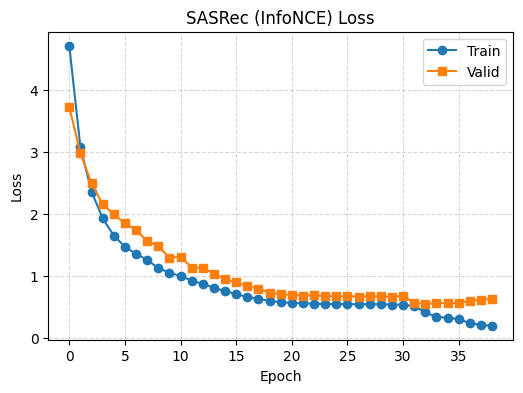

💾 已保存：/content/drive/MyDrive/gai/data/processed/sasrec_item_emb.npy | shape=(3538, 64)


In [ ]:
# ==========================
# ✅ Phase 3: Full SASRec (与 Phase 0/1/2 完全对齐)
# 读入：PROCESSED_DIR/train_slices.npy（含 {user_idx, hist, pos, neg}）
#      PROCESSED_DIR/item2idx.json
#      （可选）PROCESSED_DIR/gcn_item_embs.npy 作为 item embedding 预热
# 产出：PROCESSED_DIR/sasrec_item_emb.npy
# ==========================

import os, json, math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ===== 环境常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 0) 若上游未定义：统一的净化保存函数（NaN/Inf 清理 + L2 归一）
# --------------------------
try:
    sanitize_and_save
except NameError:
    def sanitize_and_save(path, emb_tensor):
        if not isinstance(emb_tensor, torch.Tensor):
            emb_tensor = torch.as_tensor(emb_tensor)
        emb_tensor = torch.nan_to_num(emb_tensor, nan=0.0, posinf=0.0, neginf=0.0)
        emb_tensor = F.normalize(emb_tensor, p=2, dim=1)
        np.save(path, emb_tensor.detach().cpu().numpy())

# --------------------------
# 1) 加载切片数据与映射
# --------------------------
slices_path = os.path.join(PROCESSED_DIR, "train_slices.npy")
item2idx_path = ITEM2IDX_JSON
assert os.path.exists(slices_path), f"❌ 缺少 {slices_path}"
assert os.path.exists(item2idx_path), f"❌ 缺少 {item2idx_path}"

slices = np.load(slices_path, allow_pickle=True)
item2idx = json.load(open(item2idx_path, "r", encoding="utf-8"))
n_items = len(item2idx)
print(f"✅ 加载切片: {len(slices):,} 条，物品数: {n_items:,}")

# --------------------------
# 2) EarlyStopping
# --------------------------
class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.patience, self.mode, self.delta = patience, mode, delta
        self.best, self.best_state, self.count = None, None, 0
        self.early_stop = False
    def __call__(self, score, model=None):
        improved = (self.best is None) or \
                   (score < self.best - self.delta if self.mode=="min" else score > self.best + self.delta)
        if improved:
            self.best = score
            self.count = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
            if self.count >= self.patience:
                self.early_stop = True

# --------------------------
# 3) 数据集（使用 Phase 1 切片：hist/pos/neg）
# --------------------------
MAXLEN = 50
def pad_left(x, maxlen=MAXLEN, pad_id=0):
    x = x[-maxlen:]
    if len(x) < maxlen:
        x = [pad_id]*(maxlen - len(x)) + x
    return x

class SliceDataset(Dataset):
    def __init__(self, slices, maxlen=MAXLEN):
        self.samples = []
        for rec in slices:
            hist = [int(t) for t in rec["hist"]]
            if len(hist) == 0:
                continue
            pos  = int(rec["pos"])
            neg  = int(rec["neg"])
            self.samples.append((pad_left(hist, maxlen), pos, neg))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        hist, pos, neg = self.samples[idx]
        return torch.tensor(hist, dtype=torch.long), torch.tensor(pos), torch.tensor(neg)

# 9:1 划分
all_ds = SliceDataset(slices, MAXLEN)
n_train = int(len(all_ds)*0.9)
train_ds, valid_ds = torch.utils.data.random_split(all_ds, [n_train, len(all_ds)-n_train])
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True,  num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print(f"✅ 数据集就绪：train={len(train_ds):,}, valid={len(valid_ds):,}")

# --------------------------
# 4) SASRec 模型（多头自注意 + 因果mask + padding mask）
#    forward 返回最后一个有效位置的隐藏向量（每条序列的“下一步预测”状态）
# --------------------------
class SASRec(nn.Module):
    def __init__(self, n_items, d_model=64, n_heads=4, n_layers=2, max_len=MAXLEN, dropout=0.2, pad_id=0):
        super().__init__()
        self.n_items = n_items
        self.pad_id  = pad_id
        self.max_len = max_len

        self.item_emb = nn.Embedding(n_items + 1, d_model, padding_idx=pad_id)  # 0 作为 padding
        self.pos_emb  = nn.Embedding(max_len, d_model)
        self.drop     = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln      = nn.LayerNorm(d_model, eps=1e-6)

        # 温度用于 InfoNCE
        self.tau = 0.008

    def forward(self, seq_ids):   # [B, T]
        B, T = seq_ids.size()
        pos = torch.arange(T, device=seq_ids.device).unsqueeze(0).expand(B, T)
        x = self.item_emb(seq_ids) + self.pos_emb(pos)
        x = self.drop(x)

        pad_mask = (seq_ids == self.pad_id)                # [B,T] True=mask掉
        causal   = torch.triu(torch.ones(T, T, device=seq_ids.device), diagonal=1).bool()  # [T,T]

        h = self.encoder(x, mask=causal, src_key_padding_mask=pad_mask)  # [B,T,D]
        h = self.ln(h)

        # === 3.3 前向 NaN/Inf 防护 ===
        h = torch.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)

        # 取每条序列最后一个非pad位置的隐藏状态
        lengths = (seq_ids != self.pad_id).long().sum(dim=1)  # [B]
        idx = (lengths - 1).clamp(min=0)                      # 末位置索引
        last_h = h[torch.arange(B, device=h.device), idx]     # [B,D]
        return last_h                                         # “下一步预测”状态

    def score(self, last_h, item_ids):
        # 取对应物品向量并点积打分
        E = self.item_emb(item_ids)   # [B,D]
        return (last_h * E).sum(dim=1)  # [B]

# --------------------------
# 5) 可选：用 GCN 的 item 向量预热 item_emb（结构→序列的软融合）
# --------------------------
gcn_item_path = os.path.join(PROCESSED_DIR, "gcn_item_embs.npy")
model = SASRec(n_items=n_items, d_model=64, n_heads=4, n_layers=2, max_len=MAXLEN, dropout=0.2).to(DEVICE)

if os.path.exists(gcn_item_path):
    gcn_item = np.load(gcn_item_path)  # [n_items, d]
    if gcn_item.shape[0] == n_items and gcn_item.shape[1] == model.item_emb.embedding_dim:
        with torch.no_grad():
            w = model.item_emb.weight
            w[1:] = torch.from_numpy(gcn_item).to(w.device).type_as(w)  # 1..n_items
        print("🔧 已用 gcn_item_embs.npy 预热 item_emb")
    else:
        print("ℹ️ 检测到 gcn_item_embs.npy，但形状不匹配，跳过预热。")

# --------------------------
# 6) 训练配置（InfoNCE 对比学习）
# --------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early     = EarlyStopping(patience=6, mode="min")

def info_nce_loss(last_h, pos_ids, neg_ids, tau):
    # s_pos = q·k+ / τ ; s_neg = q·k- / τ
    pos_scores = model.score(last_h, pos_ids) / tau  # [B]
    neg_scores = model.score(last_h, neg_ids) / tau  # [B]
    # 二分类 InfoNCE： -log( exp(pos) / (exp(pos)+exp(neg)) )
    logits = torch.stack([pos_scores, neg_scores], dim=1)    # [B,2]
    labels = torch.zeros(last_h.size(0), dtype=torch.long, device=last_h.device)  # 0=pos
    loss = F.cross_entropy(logits, labels)

    # === 3.3 损失 NaN/Inf 防护 ===
    if torch.isnan(loss) or torch.isinf(loss):
        loss = torch.zeros((), device=last_h.device, requires_grad=True)
    return loss

# --------------------------
# 7) 训练循环（3.1 AMP + 梯度裁剪；3.2 健壮验证）
# --------------------------
scaler = torch.cuda.amp.GradScaler(enabled=True)

def train_one_epoch():
    model.train()
    tot = 0.0
    for hist, pos, neg in train_dl:
        hist, pos, neg = hist.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=True):
            last_h = model(hist)
            loss = info_nce_loss(last_h, pos, neg, model.tau)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 3.1 梯度裁剪
        scaler.step(optimizer)
        scaler.update()
        tot += float(loss.item()) * hist.size(0)
    return tot / max(1, len(train_dl.dataset))

@torch.no_grad()
def valid_one_epoch():
    model.eval()
    tot, count = 0.0, 0
    with torch.cuda.amp.autocast(enabled=True):
        for hist, pos, neg in valid_dl:
            hist, pos, neg = hist.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
            last_h = model(hist)
            loss = info_nce_loss(last_h, pos, neg, model.tau)
            # 3.2 验证 NaN/Inf 容错：跳过异常 batch
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            tot += float(loss.item()) * hist.size(0)
            count += hist.size(0)
    return (tot / count) if count > 0 else float('inf')

EPOCHS = 40
train_losses, val_losses = [], []
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch()
    va = valid_one_epoch()
    train_losses.append(tr); val_losses.append(va)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(va)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 lr: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[SASRec] Epoch {ep:03d}/{EPOCHS} | train {tr:.6f} | valid {va:.6f} | lr {new_lr:.2e}")
    early(va, model)
    if early.early_stop:
        print(f"🛑 Early stopping at epoch {ep}")
        break

# --------------------------
# 8) 可视化：训练 / 验证 Loss
# --------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses,   label="Valid", marker="s")
plt.title("SASRec (InfoNCE) Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, ls="--", alpha=0.5); plt.legend(); plt.show()

# --------------------------
# 9) 导出 item 向量（3.4 用 sanitize_and_save 统一数值卫生）
# --------------------------
if early.best_state is not None:
    model.load_state_dict(early.best_state)

model.eval()
with torch.no_grad():
    # [n_items+1, d]；去掉 padding 行（index=0）
    item_table = model.item_emb.weight[1:, :]

out_path = os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy")
sanitize_and_save(out_path, item_table)  # 3.4：净化 + L2 归一 + 保存
print(f"💾 已保存：{out_path} | shape={tuple(item_table.shape)}")


In [ ]:
# ==========================
# ✅ Phase 4: Fusion + Contrastive Alignment（与 Phase 0/1/2/3 完全对齐）
# 读入：
#   PROCESSED_DIR/user2idx.json, item2idx.json
#   PROCESSED_DIR/train_pairs.npy（排名损失用的三元组 u,pos,neg）
#   PROCESSED_DIR/gcn_user_embs.npy, gcn_item_embs.npy（结构嵌入）
#   PROCESSED_DIR/sasrec_item_emb.npy（行为项侧嵌入）
#   （用于早停评估）PROCESSED_DIR/test_sequences.npy  ← Phase 1-① 产物
# 产出：
#   PROCESSED_DIR/fusion_user_embs.npy, PROCESSED_DIR/fusion_item_embs.npy
# ==========================

import os, json, math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 0) 若上游未定义：统一的净化保存函数（NaN/Inf 清理 + L2 归一）
# --------------------------
try:
    sanitize_and_save
except NameError:
    def sanitize_and_save(path, emb_tensor):
        if not isinstance(emb_tensor, torch.Tensor):
            emb_tensor = torch.as_tensor(emb_tensor)
        emb_tensor = torch.nan_to_num(emb_tensor, nan=0.0, posinf=0.0, neginf=0.0)
        emb_tensor = F.normalize(emb_tensor, p=2, dim=1)
        np.save(path, emb_tensor.detach().cpu().numpy())

# --------------------------
# 1) 加载映射与嵌入（与 Phase 2/3 对齐）
# --------------------------
with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)
U, I = len(user2idx), len(item2idx)
print(f"✅ 用户 {U:,}, 物品 {I:,}")

# 结构嵌入（来自 Phase 2）
gcn_user_path = os.path.join(PROCESSED_DIR, "gcn_user_embs.npy")
gcn_item_path = os.path.join(PROCESSED_DIR, "gcn_item_embs.npy")
assert os.path.exists(gcn_user_path) and os.path.exists(gcn_item_path), "❌ 缺少 GCN 嵌入文件"
gcn_users = np.load(gcn_user_path)      # [U, d]
gcn_items = np.load(gcn_item_path)      # [I, d]
assert gcn_users.shape[0]==U and gcn_items.shape[0]==I, "⚠️ GCN 嵌入数量与映射不一致"

# 行为项侧嵌入（来自 Phase 3）
sas_item_path = os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy")
assert os.path.exists(sas_item_path), "❌ 缺少 sasrec_item_emb.npy"
sas_items = np.load(sas_item_path)      # [I, d_s]
print("🔎 维度：GCN item", gcn_items.shape, "| SAS item", sas_items.shape)

# --------------------------
# 2) 用 train∪valid 构建“行为用户向量”（SASRec项侧的历史均值）— 避免读取 user_sequences.npy
# --------------------------
train_seq_path = os.path.join(PROCESSED_DIR, "train_sequences.npy")
valid_seq_path = os.path.join(PROCESSED_DIR, "valid_sequences.npy")
assert os.path.exists(train_seq_path) and os.path.exists(valid_seq_path), "❌ 缺少 train/valid 切分，请先运行 Phase 1-①"

def _load_dict_npy(p):
    obj = np.load(p, allow_pickle=True)
    # 正确保存方式：np.save(dict) → 0维object数组，可 .item()
    if isinstance(obj, np.ndarray) and obj.shape == ():
        d = obj.item()
        if isinstance(d, dict):
            return {int(k): [int(x) for x in v] for k, v in d.items()}
    # 兜底：某些环境可能直接写成 dict（pickle）
    if isinstance(obj, dict):
        return {int(k): [int(x) for x in v] for k, v in obj.items()}
    raise ValueError(f"{p} 不是 dict 格式的 .npy，请确认 Phase 1-① 的保存方式。")

train_seqs = _load_dict_npy(train_seq_path)   # {u:[items]}
valid_seqs = _load_dict_npy(valid_seq_path)

# 历史集合：train ∪ valid（与 Phase 5/6 口径一致）
user_hist = {}
for u, seq in train_seqs.items():
    user_hist[u] = set(int(i) for i in seq)
for u, seq in valid_seqs.items():
    s = user_hist.get(u, set())
    s.update(int(i) for i in seq)
    user_hist[u] = s

# 构造行为用户向量（在 sas_items 上取历史均值）
beh_users = np.zeros((U, sas_items.shape[1]), dtype=np.float32)
valid_cnt = 0
for u in range(U):
    hist = [i for i in user_hist.get(u, []) if 0 <= i < I]
    if hist:
        beh_users[u] = sas_items[hist].mean(axis=0)
        valid_cnt += 1

# 数值标准化（双侧全部 L2 归一，保持尺度一致）
def _l2(x):
    return x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-8)
gcn_users = _l2(gcn_users)
gcn_items = _l2(gcn_items)
beh_users = _l2(beh_users)
sas_items = _l2(sas_items)
print(f"✅ 行为用户向量构建完成（有历史的用户：{valid_cnt:,}/{U:,}）")

# 转 Tensor（放到统一设备）
gcn_users_t = torch.tensor(gcn_users, dtype=torch.float32, device=DEVICE)
gcn_items_t = torch.tensor(gcn_items, dtype=torch.float32, device=DEVICE)
beh_users_t = torch.tensor(beh_users, dtype=torch.float32, device=DEVICE)
beh_items_t = torch.tensor(sas_items, dtype=torch.float32, device=DEVICE)

# --------------------------
# 3) 融合器：双投影 + L2 归一（4.1）
# --------------------------
EMB = gcn_users.shape[1]  # 与 GCN 输出维度对齐（=64）
Dg, Db = gcn_items.shape[1], sas_items.shape[1]
assert Dg == EMB and Db == EMB, "⚠️ 期望 GCN/SAS 物品维度与 GCN 用户维度一致（均=64）"

class Projector(nn.Module):
    def __init__(self, d_in, d_out=EMB):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 2*d_out),
            nn.ReLU(),
            nn.Linear(2*d_out, d_out)
        )
    def forward(self, x):
        return F.normalize(self.net(x), p=2, dim=-1)  # 进入 InfoNCE 前单位球面

class FusionAligner(nn.Module):
    def __init__(self, d_in=EMB, d_proj=EMB, tau=0.004):
        super().__init__()
        self.u_g = Projector(d_in, d_proj)  # user-graph
        self.u_b = Projector(d_in, d_proj)  # user-behavior
        self.v_g = Projector(d_in, d_proj)  # item-graph
        self.v_b = Projector(d_in, d_proj)  # item-behavior
        self._tau = nn.Parameter(torch.tensor(float(tau)))
    @property
    def tau(self):
        return torch.clamp(self._tau, 0.002, 0.02)
    def forward(self, U_g, U_b, V_g, V_b):
        Ug = self.u_g(U_g); Ub = self.u_b(U_b)
        Vg = self.v_g(V_g); Vb = self.v_b(V_b)
        return Ug, Ub, Vg, Vb

def info_nce_diag(z1, z2, temp):
    logits = (z1 @ z2.T) / temp
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)

# --------------------------
# 4) 训练数据（Phase 1 的 hard neg 三元组）
# --------------------------
pairs_path = os.path.join(PROCESSED_DIR, "train_pairs.npy")
assert os.path.exists(pairs_path), "❌ 缺少 train_pairs.npy"
pairs = np.load(pairs_path, allow_pickle=True)

class PairDS(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        u, p, n = self.pairs[i]
        return int(u), int(p), int(n)

dl = DataLoader(PairDS(pairs), batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)

# --------------------------
# 5) 训练配置
# --------------------------
LAMBDA_CONTRAST = 0.15
model = FusionAligner(d_in=EMB, d_proj=EMB, tau=0.004).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best = -1.0
        self.ckpt = None
        self.wait = 0
        self.stop = False
    def step(self, metric, model):
        if metric > self.best:
            self.best = metric
            self.ckpt = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True

early = EarlyStopping(patience=5)

# --------------------------
# 6) 训练循环：对齐损失 + 排序损失（hard neg）
# --------------------------
def train_epoch():
    model.train()
    total = 0.0
    for u, pos, neg in dl:
        u, pos, neg = u.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        Ug, Ub, Vg, Vb = model(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
        tau = model.tau

        L_align = info_nce_diag(Ug, Ub, tau) + info_nce_diag(Vg, Vb, tau)

        u_vec   = 0.5*(Ug[u] + Ub[u])        # 用户融合
        pos_vec = 0.5*(Vg[pos] + Vb[pos])    # 正样本融合
        neg_vec = 0.5*(Vg[neg] + Vb[neg])    # 负样本融合
        pos_s   = (u_vec * pos_vec).sum(-1) / tau
        neg_s   = (u_vec * neg_vec).sum(-1) / tau
        L_rank  = F.softplus(-(pos_s - neg_s)).mean()

        loss = LAMBDA_CONTRAST * L_align + L_rank
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total += loss.item() * u.size(0)
    return total / len(dl.dataset)

# --------------------------
# 4.4 早停指标：使用 Recall@10（no filter, full ranking）
# --------------------------
test_path = os.path.join(PROCESSED_DIR, "test_sequences.npy")
assert os.path.exists(test_path), "❌ 缺少 test_sequences.npy（来自 Phase 1-①）"
test_seq = np.load(test_path, allow_pickle=True)
if isinstance(test_seq, np.ndarray) and test_seq.shape == ():
    test_seq = test_seq.item()  # dict
assert isinstance(test_seq, dict), "test_sequences.npy 不是 dict，请检查 Phase 1-① 的保存。"

def build_history_dict(train_path, valid_path):
    hist = {}
    for p in (train_path, valid_path):
        if not os.path.exists(p):
            continue
        d = np.load(p, allow_pickle=True)
        if isinstance(d, np.ndarray) and d.shape == ():
            d = d.item()
        for u, seq in d.items():
            s = hist.get(u, set())
            s.update(int(i) for i in seq)
            hist[u] = s
    return hist

user_hist_set = build_history_dict(train_seq_path, valid_seq_path)

@torch.no_grad()
def eval_recall_at_k(model, k=10, filter_history=False):
    model.eval()
    Ug, Ub, Vg, Vb = model(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
    U_fused = F.normalize(0.5*Ug + 0.5*Ub, dim=-1)
    V_fused = F.normalize(0.5*Vg + 0.5*Vb, dim=-1)

    users = [u for u, seq in test_seq.items() if isinstance(seq, (list, tuple)) and len(seq) >= 1]
    if len(users) == 0:
        return 0.0

    batch_size = 4096
    hits, total = 0, 0
    for i in range(0, len(users), batch_size):
        batch_users = users[i:i+batch_size]
        U_mat = U_fused[batch_users]                    # [B, D]
        scores = U_mat @ V_fused.T                      # [B, I]

        if filter_history:
            for bi, u in enumerate(batch_users):
                for it in user_hist_set.get(u, ()):
                    if 0 <= it < I:
                        scores[bi, it] = -1e30

        topk_idx = torch.topk(scores, k=k, dim=1).indices  # [B, k]
        for bi, u in enumerate(batch_users):
            tgt_list = test_seq.get(u, [])
            if not tgt_list:
                continue
            tgt = int(tgt_list[-1])  # Phase1-①: test_tail=1
            if 0 <= tgt < I:
                total += 1
                if (topk_idx[bi] == tgt).any():
                    hits += 1
    return hits / max(1, total)

# --------------------------
# 训练 + 基于 Recall@10 的早停
# --------------------------
EPOCHS = 30
hist_loss, hist_r10 = [], []

for ep in range(1, EPOCHS+1):
    loss = train_epoch()
    r10  = eval_recall_at_k(model, k=10, filter_history=False)  # 早停指标
    hist_loss.append(loss); hist_r10.append(r10)

    old_lr = opt.param_groups[0]['lr']
    scheduler.step(loss)
    new_lr = opt.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 学习率下降: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[Fusion] Epoch {ep:03d}/{EPOCHS} | Loss {loss:.6f} | Recall@10 {r10:.4f} | τ={model.tau.item():.4f} | lr {new_lr:.2e}")

    early.step(r10, model)  # 更高的 Recall 更好
    if early.stop:
        print(f"🛑 Early stopping at epoch {ep}（基于 Recall@10）")
        break

# 还原最佳
if early.ckpt is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in early.ckpt.items()})

# --------------------------
# 7) 导出融合向量（使用 sanitize_and_save 统一数值卫生）
# --------------------------
model.eval()
with torch.no_grad():
    Ug, Ub, Vg, Vb = model(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
    U_fused = 0.5*Ug + 0.5*Ub
    V_fused = 0.5*Vg + 0.5*Vb

out_u = os.path.join(PROCESSED_DIR, "fusion_user_embs.npy")
out_v = os.path.join(PROCESSED_DIR, "fusion_item_embs.npy")
sanitize_and_save(out_u, U_fused)
sanitize_and_save(out_v, V_fused)
print(f"💾 已保存（净化后）：\n - {out_u} {tuple(U_fused.shape)}\n - {out_v} {tuple(V_fused.shape)}")


🧠 Using device: cuda
✅ 用户 1,708, 物品 3,538
🔎 维度：GCN item (3538, 64) | SAS item (3538, 64)
✅ 行为用户向量构建完成（有历史的用户：1,708/1,708）
[Fusion] Epoch 001/30 | Loss 4.209238 | Recall@10 0.0105 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 002/30 | Loss 2.989035 | Recall@10 0.0123 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 003/30 | Loss 2.942387 | Recall@10 0.0123 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 004/30 | Loss 2.903328 | Recall@10 0.0141 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 005/30 | Loss 2.870059 | Recall@10 0.0146 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 006/30 | Loss 2.841998 | Recall@10 0.0129 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 007/30 | Loss 2.824708 | Recall@10 0.0141 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 008/30 | Loss 2.797974 | Recall@10 0.0158 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 009/30 | Loss 2.767959 | Recall@10 0.0141 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 010/30 | Loss 2.740932 | Recall@10 0.0222 | τ=0.0200 | lr 2.00e-03
[Fusion] Epoch 011/30 | Loss 2.716262 | Recall@10 0.0187 |

📘 加载切分：train=1,708 | valid=1,708 | test=1,708
✅ 测试用户数：1,708
🔧 SAS 用户向量可用：1,708/1,708

📊 Evaluation Summary (no_filter):
{
  "users_eval": 1708,
  "filter_history": false,
  "metrics": {
    "GCN": {
      "Recall": {
        "5": 0.006440281030444965,
        "10": 0.008782201405152224,
        "20": 0.01405152224824356
      },
      "NDCG": {
        "5": 0.004653664589507841,
        "10": 0.005407860688069586,
        "20": 0.006730570472448366
      },
      "HitRate": {
        "5": 0.006440281030444965,
        "10": 0.008782201405152224,
        "20": 0.01405152224824356
      },
      "MRR": {
        "5": 0.004069086651053864,
        "10": 0.004378090033827739,
        "20": 0.004736459084419148
      },
      "AUC": 0.6244072014051524
    },
    "SASRec": {
      "Recall": {
        "5": 0.002927400468384075,
        "10": 0.00819672131147541,
        "20": 0.01522248243559719
      },
      "NDCG": {
        "5": 0.0014845229049250575,
        "10": 0.003154231164794782,
 

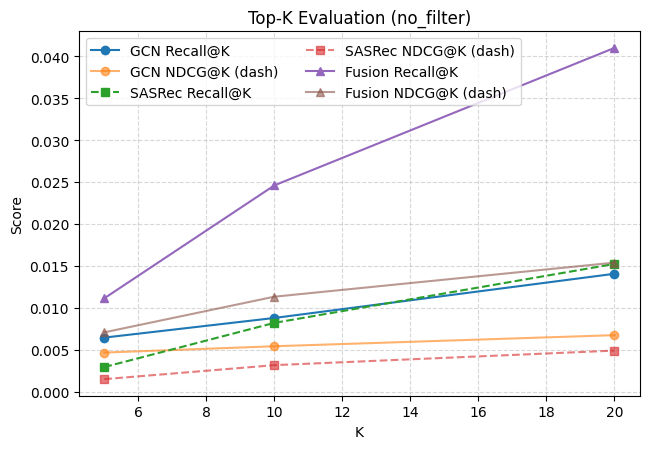

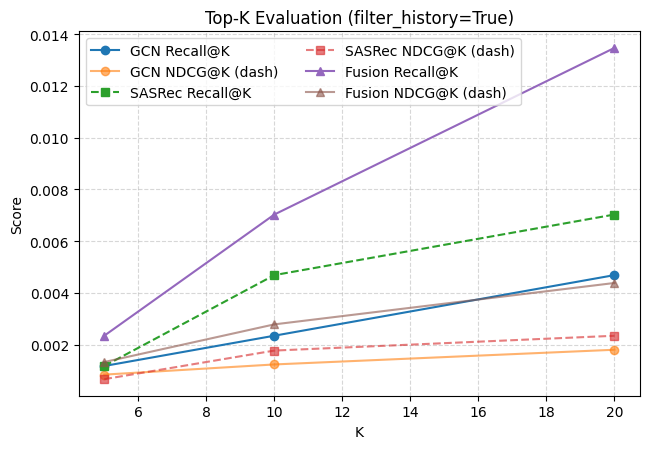

In [ ]:
# ==========================
# ✅ Phase 5: Evaluation (Recall/NDCG/HitRate/MRR/AUC)
# 与 Phase 0/1/2/3/4 完全对齐；用户内时间留出；三模型对比
# 输出：eval_dual.json + 曲线图（可选）
# ==========================

import os, json, math, random, numpy as np
import matplotlib.pyplot as plt

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON

# --------------------------
# 0) 加载必要文件（与前面阶段对齐）
# --------------------------
train_seq_path = os.path.join(PROCESSED_DIR, "train_sequences.npy")
valid_seq_path = os.path.join(PROCESSED_DIR, "valid_sequences.npy")
test_seq_path  = os.path.join(PROCESSED_DIR, "test_sequences.npy")

with open(USER2IDX_JSON, "r", encoding="utf-8") as f: user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f: item2idx = json.load(f)
U, I = len(user2idx), len(item2idx)

assert os.path.exists(train_seq_path), f"❌ 缺少 {train_seq_path}"
assert os.path.exists(valid_seq_path), f"❌ 缺少 {valid_seq_path}"
assert os.path.exists(test_seq_path),  f"❌ 缺少 {test_seq_path}"

train_seqs = np.load(train_seq_path, allow_pickle=True).item()  # {u: [items]}
valid_seqs = np.load(valid_seq_path, allow_pickle=True).item()
test_seqs  = np.load(test_seq_path,  allow_pickle=True).item()

print(f"📘 加载切分：train={len(train_seqs):,} | valid={len(valid_seqs):,} | test={len(test_seqs):,}")

# 嵌入：GCN / SASRec / Fusion（均已在各阶段保存时做 sanitize+L2）
gcn_u = np.load(os.path.join(PROCESSED_DIR, "gcn_user_embs.npy"))      # [U,d]
gcn_i = np.load(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"))      # [I,d]
sas_i = np.load(os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy"))    # [I,d]
fused_u = np.load(os.path.join(PROCESSED_DIR, "fusion_user_embs.npy")) # [U,d]
fused_i = np.load(os.path.join(PROCESSED_DIR, "fusion_item_embs.npy")) # [I,d]

assert gcn_u.shape[0]==U and gcn_i.shape[0]==I, "GCN 维度不匹配"
assert sas_i.shape[0]==I, "SASRec item 维度不匹配"
assert fused_u.shape[0]==U and fused_i.shape[0]==I, "Fusion 维度不匹配"

# 二次归一化（保险）
def _norm(x): return x / (np.linalg.norm(x, axis=1, keepdims=True)+1e-8)
gcn_u, gcn_i  = _norm(gcn_u), _norm(gcn_i)
sas_i         = _norm(sas_i)
fused_u, fused_i = _norm(fused_u), _norm(fused_i)

# --------------------------
# 1) 历史集合（用于 filter_history=True）
#    —— 与 Phase 4 早停评估保持一致：历史 = train ∪ valid
# --------------------------
user_hist = {}
for u, seq in train_seqs.items():
    user_hist[u] = set(int(i) for i in seq)
for u, seq in valid_seqs.items():
    s = user_hist.get(u, set())
    s.update(int(i) for i in seq)
    user_hist[u] = s

# --------------------------
# 2) 测试拆分（test_sequences：通常每用户 1 个末尾项；若≥1则都评估）
# --------------------------
test_split = [(int(u), [int(i) for i in items]) for u, items in test_seqs.items() if isinstance(items, (list, tuple)) and len(items) >= 1]
print(f"✅ 测试用户数：{len(test_split):,}")

# --------------------------
# 3) 构造三模型的“用户向量”
#    - GCN: 直接用 gcn_u
#    - SAS: 用（train∪valid）的项侧均值（不泄露 test）
#    - Fusion: 直接用 fused_u
# --------------------------
sas_u = np.zeros_like(gcn_u)
valid_sas_u = 0
for u in range(U):
    hist = list(user_hist.get(u, []))
    if len(hist) > 0:
        hist_clip = [i for i in hist if 0 <= i < I]
        if hist_clip:
            sas_u[u] = sas_i[hist_clip].mean(axis=0)
            valid_sas_u += 1
sas_u = _norm(sas_u)
print(f"🔧 SAS 用户向量可用：{valid_sas_u:,}/{U:,}")

# --------------------------
# 4) 评估函数与指标
# --------------------------
Ks = [5, 10, 20]

def recommend_topk(user_vecs, item_vecs, u_idx, k=500, forbid=None):
    """给定用户/物品向量库，返回用户u的Top-K（可选择过滤历史）"""
    u = user_vecs[u_idx:u_idx+1]      # [1,d]
    scores = (u @ item_vecs.T).ravel()
    if forbid:
        # 将历史物品屏蔽（置极小），以实现 filter_history=True 的口径
        idxs = list(forbid)
        idxs = [i for i in idxs if 0 <= i < item_vecs.shape[0]]
        if idxs:
            scores[idxs] = -1e12
    # top-k argsort
    idx = np.argpartition(-scores, k)[:k]
    idx = idx[np.argsort(-scores[idx])]
    return idx, scores

def binary_auc(pos_score, neg_scores):
    greater = np.sum(pos_score > neg_scores)
    ties    = np.sum(pos_score == neg_scores)
    n = len(neg_scores)
    return (greater + 0.5 * ties)/n if n>0 else 0.5

def dcg_at_k(y_true, ranked, k):
    dcg = 0.0
    for i, it in enumerate(ranked[:k], 1):
        if it in y_true:
            dcg += 1.0/np.log2(i+1)
    return dcg

def ndcg_at_k(y_true, ranked, k):
    ideal = min(len(y_true), k)
    idcg = sum(1.0/np.log2(i+1) for i in range(1, ideal+1))
    return (dcg_at_k(y_true, ranked, k)/idcg) if idcg>0 else 0.0

def mrr_at_k(y_true, ranked, k):
    for i, it in enumerate(ranked[:k], 1):
        if it in y_true:
            return 1.0/i
    return 0.0

def hit_rate_at_k(y_true, ranked, k):
    return 1.0 if len(y_true.intersection(set(ranked[:k])))>0 else 0.0

# 三模型封装
MODELS = {
    "GCN":    (gcn_u,   gcn_i),
    "SASRec": (sas_u,   sas_i),
    "Fusion": (fused_u, fused_i),
}

def evaluate_all(filter_history: bool):
    results = {m:{
        "Recall":{k:[] for k in Ks},
        "NDCG":  {k:[] for k in Ks},
        "HitRate":{k:[] for k in Ks},
        "MRR":   {k:[] for k in Ks},
        "AUC":   []
    } for m in MODELS.keys()}

    users_eval = 0
    for (u, test_items) in test_split:
        test_set = set(test_items)
        if len(test_set)==0:
            continue
        users_eval += 1

        forbid = user_hist.get(u, None) if filter_history else None

        for name, (U_vecs, I_vecs) in MODELS.items():
            ranked, scores = recommend_topk(U_vecs, I_vecs, u_idx=u, k=500, forbid=forbid)
            # AUC：取测试集首个正样本 vs 随机负样本（轻量版）
            pos = test_items[0]
            if 0 <= pos < I:
                neg_pool = list(set(range(I)) - {pos})
                samp = random.sample(neg_pool, min(1000, len(neg_pool))) if neg_pool else []
                results[name]["AUC"].append(binary_auc(scores[pos], scores[samp]) if samp else 0.5)

            for K in Ks:
                topK = ranked[:K].tolist()
                results[name]["Recall"][K].append(len(test_set.intersection(set(topK)))/max(1,len(test_set)))
                results[name]["NDCG"][K].append(ndcg_at_k(test_set, ranked, K))
                results[name]["HitRate"][K].append(hit_rate_at_k(test_set, ranked, K))
                results[name]["MRR"][K].append(mrr_at_k(test_set, ranked, K))

    def avg(lst): return float(np.mean(lst)) if lst else 0.0
    report = {}
    for name in MODELS.keys():
        report[name] = {
            "Recall": {k: avg(results[name]["Recall"][k]) for k in Ks},
            "NDCG":   {k: avg(results[name]["NDCG"][k])   for k in Ks},
            "HitRate":{k: avg(results[name]["HitRate"][k])for k in Ks},
            "MRR":    {k: avg(results[name]["MRR"][k])    for k in Ks},
            "AUC":    avg(results[name]["AUC"])
        }
    summary = {
        "users_eval": int(users_eval),
        "filter_history": bool(filter_history),
        "metrics": report
    }
    return summary

# --------------------------
# 5) 双口径评估并保存（no_filter & filter_history=True）
# --------------------------
summary_no_filter = evaluate_all(filter_history=False)
summary_filter    = evaluate_all(filter_history=True)

print("\n📊 Evaluation Summary (no_filter):")
print(json.dumps(summary_no_filter, ensure_ascii=False, indent=2))
print("\n📊 Evaluation Summary (filter_history=True):")
print(json.dumps(summary_filter, ensure_ascii=False, indent=2))

out_json = os.path.join(PROCESSED_DIR, "eval_dual.json")
with open(out_json, "w", encoding="utf-8") as f:
    json.dump({"no_filter": summary_no_filter, "filter": summary_filter}, f, ensure_ascii=False, indent=2)
print(f"💾 已保存：{out_json}")

# --------------------------
# 6) 可视化（可选）：三模型对比（分别画 no_filter 与 filter）
# --------------------------
def _int_keys(d):
    """把度量字典的键统一转成 int，兼容内存对象和从 JSON 读回后的字符串键"""
    return {int(k): v for k, v in d.items()}

def plot_curves(summary, title):
    report = summary["metrics"]

    # 统一把 Recall/NDCG 的 K 键转成 int，防止 '5'/'10'/'20' 与 5/10/20 混用导致 KeyError
    rec = {name: _int_keys(report[name]["Recall"]) for name in ["GCN","SASRec","Fusion"]}
    ndc = {name: _int_keys(report[name]["NDCG"])   for name in ["GCN","SASRec","Fusion"]}

    Ks_sorted = sorted(set().union(*[rec[name].keys() for name in rec.keys()]))

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6.6,4.6))
    styles = {"GCN":"o-","SASRec":"s--","Fusion":"^-"}
    for name in ["GCN","SASRec","Fusion"]:
        plt.plot(Ks_sorted, [rec[name][k] for k in Ks_sorted], styles[name], label=f"{name} Recall@K")
        plt.plot(Ks_sorted, [ndc[name][k] for k in Ks_sorted], styles[name], alpha=0.6, label=f"{name} NDCG@K (dash)")
    plt.title(title)
    plt.xlabel("K"); plt.ylabel("Score")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# 如需可视化，取消下面两行注释
plot_curves(summary_no_filter,        "Top-K Evaluation (no_filter)")
plot_curves(summary_filter,           "Top-K Evaluation (filter_history=True)")


✅ 测试用户数：1,708
🔧 SAS 用户向量可用：1,708/1,708


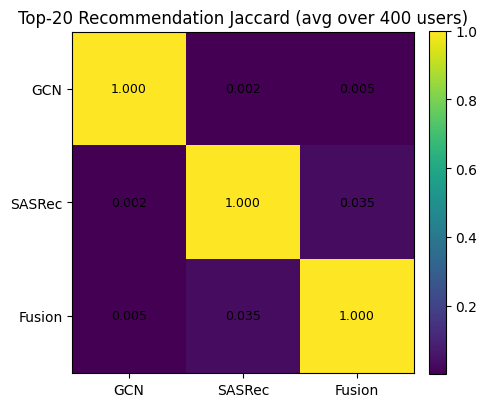

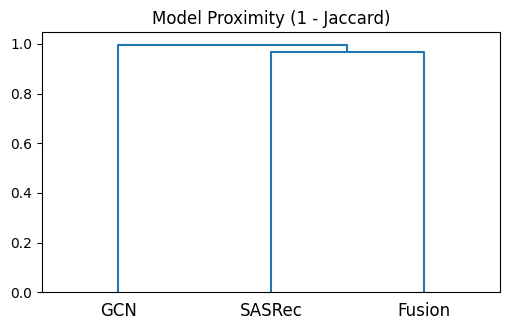

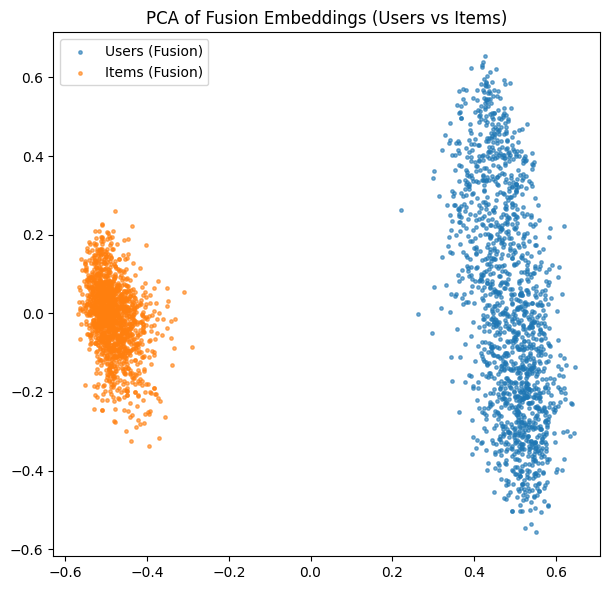

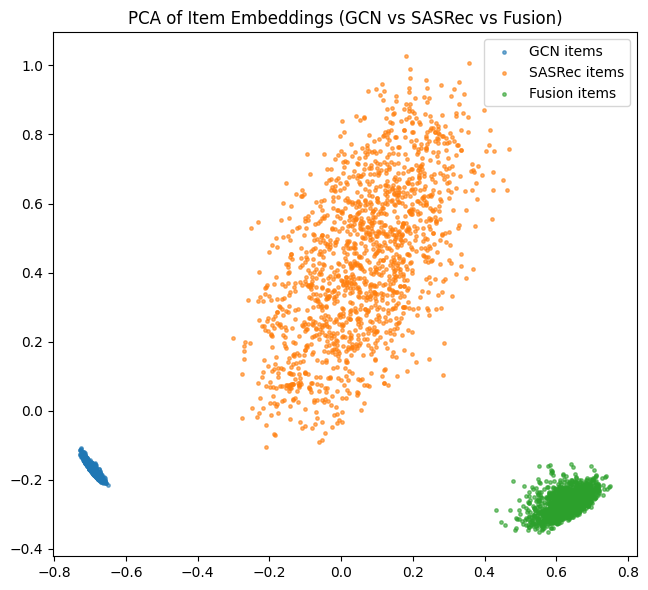

💾 可视化输出：
 - /content/drive/MyDrive/gai/data/processed/figs/phase6_jaccard_top20.png
 - /content/drive/MyDrive/gai/data/processed/figs/phase6_pca_fusion_user_item.png
 - /content/drive/MyDrive/gai/data/processed/figs/phase6_pca_items_three_models.png
 - /content/drive/MyDrive/gai/data/processed/vis_summary.json


In [ ]:
# ==========================
# ✅ Phase 6: Visualization & Overlap Analysis (与 Phase 0–5 完全对齐)
# 读取：
#   PROCESSED_DIR/{train_sequences.npy, valid_sequences.npy, test_sequences.npy}
#   PROCESSED_DIR/{gcn_user_embs.npy, gcn_item_embs.npy, sasrec_item_emb.npy,
#                  fusion_user_embs.npy, fusion_item_embs.npy}
# 输出：
#   /.../processed/figs/*.png ； /.../processed/vis_summary.json
# 口径：
#   - 历史集合：train ∪ valid（与 Phase 4/5 的过滤一致）
#   - 用户集合：test_sequences 的用户（有测试项）
# ==========================

import os, json, random, numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON

# --------------------------
# 0) 加载映射与嵌入（均为 sanitize_and_save 后的结果；此处仍二次 L2 保险）
# --------------------------
with open(USER2IDX_JSON, "r", encoding="utf-8") as f: user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f: item2idx = json.load(f)
U, I = len(user2idx), len(item2idx)

gcn_u = np.load(os.path.join(PROCESSED_DIR, "gcn_user_embs.npy"))      # [U,d]
gcn_i = np.load(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"))      # [I,d]
sas_i = np.load(os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy"))    # [I,d]
fus_u = np.load(os.path.join(PROCESSED_DIR, "fusion_user_embs.npy"))   # [U,d]
fus_i = np.load(os.path.join(PROCESSED_DIR, "fusion_item_embs.npy"))   # [I,d]

assert gcn_u.shape[0]==U and gcn_i.shape[0]==I, "GCN 维度不匹配"
assert sas_i.shape[0]==I, "SASRec item 维度不匹配"
assert fus_u.shape[0]==U and fus_i.shape[0]==I, "Fusion 维度不匹配"

def _norm(x): return x / (np.linalg.norm(x, axis=1, keepdims=True)+1e-8)
gcn_u, gcn_i  = _norm(gcn_u), _norm(gcn_i)
sas_i         = _norm(sas_i)
fus_u, fus_i  = _norm(fus_u), _norm(fus_i)

# --------------------------
# 1) 载入 Phase 1 切分，并构造历史= train∪valid（对齐 Phase 5 过滤口径）
# --------------------------
train_seq_path = os.path.join(PROCESSED_DIR, "train_sequences.npy")
valid_seq_path = os.path.join(PROCESSED_DIR, "valid_sequences.npy")
test_seq_path  = os.path.join(PROCESSED_DIR, "test_sequences.npy")
assert os.path.exists(train_seq_path) and os.path.exists(valid_seq_path) and os.path.exists(test_seq_path), "❌ 缺少 Phase 1 切分文件"

train_seqs = np.load(train_seq_path, allow_pickle=True).item()  # {u: [items]}
valid_seqs = np.load(valid_seq_path, allow_pickle=True).item()
test_seqs  = np.load(test_seq_path,  allow_pickle=True).item()

# 历史集合（train ∪ valid）
user_hist = {}
for u, seq in train_seqs.items():
    user_hist[u] = set(int(i) for i in seq)
for u, seq in valid_seqs.items():
    s = user_hist.get(u, set())
    s.update(int(i) for i in seq)
    user_hist[u] = s

# 测试用户集合（仅使用 test 中存在至少一项的用户）
test_split = [(int(u), [int(i) for i in items]) for u, items in test_seqs.items() if isinstance(items, (list, tuple)) and len(items) >= 1]
print(f"✅ 测试用户数：{len(test_split):,}")

# --------------------------
# 2) 构造三模型“用户库”
#    - GCN：直接用 gcn_u
#    - SASRec：用（train∪valid）历史在 sas_i 上的均值（防止泄露 test）
#    - Fusion：直接用 fus_u
# --------------------------
sas_u = np.zeros_like(gcn_u)
valid_sas_u = 0
for u in range(U):
    hist = list(user_hist.get(u, []))
    if hist:
        hist = [i for i in hist if 0 <= i < I]
        if hist:
            sas_u[u] = sas_i[hist].mean(axis=0)
            valid_sas_u += 1
sas_u = _norm(sas_u)
print(f"🔧 SAS 用户向量可用：{valid_sas_u:,}/{U:,}")

# --------------------------
# 3) 函数：Top-K 推荐、Jaccard
# --------------------------
def recommend_topk(user_vecs, item_vecs, u_idx, k=100, forbid=None):
    u = user_vecs[u_idx:u_idx+1]        # [1,d]
    scores = (u @ item_vecs.T).ravel()  # [I]
    if forbid:
        idxs = [i for i in forbid if 0 <= i < item_vecs.shape[0]]
        if idxs:
            scores[idxs] = -1e12
    idx = np.argpartition(-scores, k)[:k]
    idx = idx[np.argsort(-scores[idx])]
    return idx

def jaccard(a_set, b_set):
    inter = len(a_set & b_set)
    union = len(a_set | b_set) if len(a_set | b_set) > 0 else 1
    return inter / union

# 三模型库
models = {
    "GCN":    (gcn_u, gcn_i),
    "SASRec": (sas_u, sas_i),
    "Fusion": (fus_u, fus_i),
}

# --------------------------
# 4) Top-K 重叠：两两 Jaccard（与 Phase 5 同口径：filter_history 可开关）
# --------------------------
K = 20
filter_history = True
MAX_USERS_VIS = 400   # 可视化用户抽样上限
random.seed(2025)

users_for_vis = [u for (u, _t) in test_split]
if len(users_for_vis) > MAX_USERS_VIS:
    users_for_vis = random.sample(users_for_vis, MAX_USERS_VIS)

# 逐用户 TopK 集合
topk_sets = {name: [] for name in models}
for u in users_for_vis:
    forbid = user_hist.get(u, None) if filter_history else None
    for name, (Uvec, Ivec) in models.items():
        ranked = recommend_topk(Uvec, Ivec, u, k=K, forbid=forbid)
        topk_sets[name].append(set(ranked.tolist()))

# 两两平均 Jaccard
names = list(models.keys())
J = np.zeros((len(names), len(names)), dtype=float)
for i, a in enumerate(names):
    for j, b in enumerate(names):
        vals = [jaccard(A, B) for A, B in zip(topk_sets[a], topk_sets[b])]
        J[i, j] = float(np.mean(vals)) if len(vals) > 0 else 0.0

# --------------------------
# 5) 可视化：Jaccard 热力图 + （可选）层次聚类
# --------------------------
fig_dir = os.path.join(PROCESSED_DIR, "figs")
os.makedirs(fig_dir, exist_ok=True)

plt.figure(figsize=(4.8,4.2))
plt.imshow(J, interpolation='nearest')
plt.xticks(range(len(names)), names, rotation=0)
plt.yticks(range(len(names)), names)
for i in range(len(names)):
    for j in range(len(names)):
        plt.text(j, i, f"{J[i,j]:.3f}", ha='center', va='center', fontsize=9)
plt.title(f"Top-{K} Recommendation Jaccard (avg over {len(users_for_vis)} users)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"phase6_jaccard_top{K}.png"), dpi=200)
plt.show()

# （可选）层次聚类树（scipy 可用则绘制）
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    D = 1.0 - J
    np.fill_diagonal(D, 0.0)
    tri = D[np.triu_indices(len(names), k=1)]
    Z = linkage(tri, method='average')
    plt.figure(figsize=(5.2,3.4))
    dendrogram(Z, labels=names)
    plt.title("Model Proximity (1 - Jaccard)")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"phase6_dendrogram_top{K}.png"), dpi=200)
    plt.show()
except Exception as e:
    print("（提示）scipy 不可用或聚类失败，已跳过树状图：", e)

# --------------------------
# 6) 嵌入空间 PCA（图1：Fusion 用户 vs 物品）
# --------------------------
MAX_VIS = 1500  # 更保守的子集规模（与我们前面的建议一致）
n_u_vis = min(MAX_VIS, fus_u.shape[0])
n_v_vis = min(MAX_VIS, fus_i.shape[0])
U_vis = fus_u[:n_u_vis]
V_vis = fus_i[:n_v_vis]
X = np.vstack([U_vis, V_vis])
labels = np.array([0]*n_u_vis + [1]*n_v_vis)

pca = PCA(n_components=2, random_state=2025)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6.2,6.0))
plt.scatter(X2[labels==0,0], X2[labels==0,1], s=6, alpha=0.6, label="Users (Fusion)")
plt.scatter(X2[labels==1,0], X2[labels==1,1], s=6, alpha=0.6, label="Items (Fusion)")
plt.legend()
plt.title("PCA of Fusion Embeddings (Users vs Items)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "phase6_pca_fusion_user_item.png"), dpi=200)
plt.show()

# --------------------------
# 7) 嵌入空间 PCA（图2：三模型的“物品空间”几何）
# --------------------------
stack_n = min(MAX_VIS, I)
stack_items = np.vstack([gcn_i[:stack_n], sas_i[:stack_n], fus_i[:stack_n]])
stack_labels = np.array([0]*stack_n + [1]*stack_n + [2]*stack_n)  # 0:GCN 1:SAS 2:Fusion
pca2 = PCA(n_components=2, random_state=2025)
Y2 = pca2.fit_transform(stack_items)

plt.figure(figsize=(6.6,6.0))
plt.scatter(Y2[stack_labels==0,0], Y2[stack_labels==0,1], s=6, alpha=0.6, label="GCN items")
plt.scatter(Y2[stack_labels==1,0], Y2[stack_labels==1,1], s=6, alpha=0.6, label="SASRec items")
plt.scatter(Y2[stack_labels==2,0], Y2[stack_labels==2,1], s=6, alpha=0.6, label="Fusion items")
plt.legend()
plt.title("PCA of Item Embeddings (GCN vs SASRec vs Fusion)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "phase6_pca_items_three_models.png"), dpi=200)
plt.show()

# --------------------------
# 8) 数值摘要保存
# --------------------------
summary = {
    "users_used_for_overlap": int(len(users_for_vis)),
    "topK": int(K),
    "filter_history": bool(filter_history),
    "avg_jaccard_matrix": {names[i]: {names[j]: float(J[i,j]) for j in range(len(names))} for i in range(len(names))}
}
with open(os.path.join(PROCESSED_DIR, "vis_summary.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("💾 可视化输出：")
print(" -", os.path.join(fig_dir, f"phase6_jaccard_top{K}.png"))
print(" -", os.path.join(fig_dir, "phase6_pca_fusion_user_item.png"))
print(" -", os.path.join(fig_dir, "phase6_pca_items_three_models.png"))
print(" -", os.path.join(PROCESSED_DIR, "vis_summary.json"))


📦 物品总数 I = 3538
🔍 每个模型参与 t-SNE 的物品数：800，总点数：2400
🚀 开始 t-SNE 降维（可能需要几十秒）...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.000s...
[t-SNE] Computed neighbors for 2400 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 0.004266


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.857155
[t-SNE] KL divergence after 2000 iterations: 1.483949


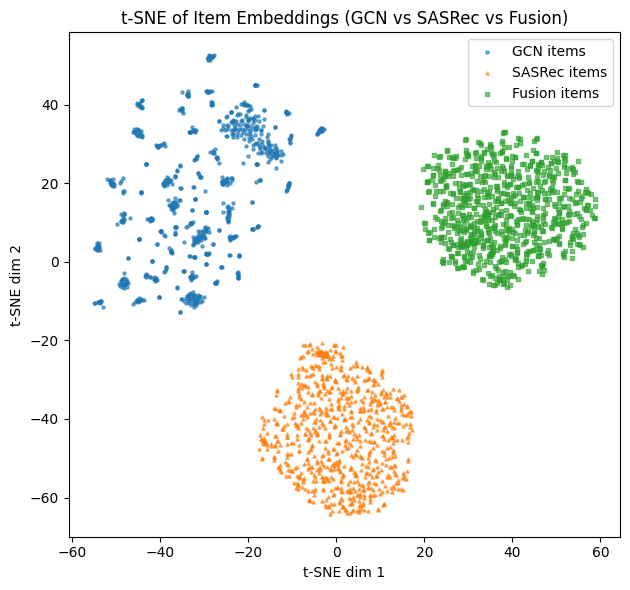

💾 已保存 t-SNE 图： /content/drive/MyDrive/gai/data/processed/figs/phase6_tsne_items_three_models.png


In [7]:
# ===========================================
# ✅ Phase 6-TSNE: 三模型 Item 嵌入的 t-SNE 可视化
# 读取：
#   PROCESSED_DIR/{gcn_item_embs.npy, sasrec_item_emb.npy, fusion_item_embs.npy}
# 输出：
#   PROCESSED_DIR/figs/phase6_tsne_items_three_models.png
# ===========================================

import os, json, numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- 路径与映射（与前面 Phase 0/6 保持一致）---
fig_dir = os.path.join(PROCESSED_DIR, "figs")
os.makedirs(fig_dir, exist_ok=True)

with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)
I = len(item2idx)
print(f"📦 物品总数 I = {I}")

# --- 加载三种 item 嵌入 ---
gcn_i = np.load(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"))      # [I, d]
sas_i = np.load(os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy"))    # [I, d]
fus_i = np.load(os.path.join(PROCESSED_DIR, "fusion_item_embs.npy"))   # [I, d]

assert gcn_i.shape[0] == I and sas_i.shape[0] == I and fus_i.shape[0] == I, "❌ 嵌入维度与 item 数量不匹配"

# --- 简单 L2 归一化，保证余弦距离可用 ---
def _norm(x):
    return x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-8)

gcn_i = _norm(gcn_i)
sas_i = _norm(sas_i)
fus_i = _norm(fus_i)

# --- 为了 t-SNE 稳定性，对每个模型抽样同样数量的 item ---
MAX_PER_MODEL = 800   # 可以根据显存/时间调节（总点数约 3 * MAX_PER_MODEL）
rng = np.random.default_rng(2025)

idx_all = np.arange(I)
rng.shuffle(idx_all)
sel = idx_all[:min(I, MAX_PER_MODEL)]

gcn_vis = gcn_i[sel]
sas_vis = sas_i[sel]
fus_vis = fus_i[sel]

print(f"🔍 每个模型参与 t-SNE 的物品数：{len(sel)}，总点数：{3*len(sel)}")

# --- 拼接后做 t-SNE ---
X = np.vstack([gcn_vis, sas_vis, fus_vis])
labels = np.array(
    [0] * len(gcn_vis) +
    [1] * len(sas_vis) +
    [2] * len(fus_vis)
)

tsne = TSNE(
    n_components=2,
    perplexity=30,          # 一般取 5~50，这里数据量较大用 30
    learning_rate="auto",
    init="random",
    metric="cosine",        # 与归一化嵌入相配
    random_state=2025,
    n_iter=2000,
    verbose=1
)

print("🚀 开始 t-SNE 降维（可能需要几十秒）...")
X2 = tsne.fit_transform(X)

# --- 绘图 ---
plt.figure(figsize=(6.4, 6.0))

for lab, name, marker in [
    (0, "GCN items", "o"),
    (1, "SASRec items", "^"),
    (2, "Fusion items", "s"),
]:
    plt.scatter(
        X2[labels == lab, 0],
        X2[labels == lab, 1],
        s=5,
        alpha=0.6,
        marker=marker,
        label=name
    )

plt.legend()
plt.title("t-SNE of Item Embeddings (GCN vs SASRec vs Fusion)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()

out_path = os.path.join(fig_dir, "phase6_tsne_items_three_models.png")
plt.savefig(out_path, dpi=200)
plt.show()

print("💾 已保存 t-SNE 图：", out_path)
